In [1]:
import os
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy.crs as ccrs
import statsmodels.api as sm
import scipy.stats
import sklearn.linear_model
from scipy.signal import detrend as scdetrend
#from xscale.xscale.signal.fitting import detrend as xdetrend
import matplotlib.ticker

In [2]:
import line.tools as ltls
import line.plot as lplt
import line.shape as lshp
#import skextremes

In [3]:
#from importlib import reload
#ltls = reload(ltls)
#lplt = reload(lplt)
#lshp = reload(lshp)
#skextremes = reload(skextremes)

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
varName = 'tas' # ts tas
region = 'NEU'
season = 'JFM'
ripf = ['r'+str(i)+'i1p1f2' for i in range(1, 31)]
experiment = ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']
#experiment = ['hist-ssp126', 'hist-ssp245', 'hist-ssp585']
driversNames = ['amoc30N', 'NAO'] # amoc30N AMV NAO EAP BL
#driversNames = ['AMV', 'NAO']
model = 'CNRM-CM6-1'
antStart = 1995
antEnd = 2014
postStart = 2020
postEnd = 2039
#antStart = 1960
#antEnd = 1979
#postStart = 1995
#postEnd = 2014

returnPeriod = 10

extrema = ('min_ano', 'max_ano', 'min_raw', 'max_raw')
          # min_ano max_ano min_raw

yFilter = 10

In [6]:
figDir = '/data/scratch/globc/line/previntep/figures/paper/'

In [7]:
if season == 'JFM':
    season_txt ='hivernal'

In [8]:
def daily_climatology(days, y_start, y_end, rolling_days=10):
    import numpy
    import xarray
    import scipy
    
    tmp = list(days.groupby('time.year'))
    _years = []
    _arrays = []
    for i in range(0, len(tmp)):
        _years.append(tmp[i][0])
        if len(tmp[i][1].time) == 366:
            _array_to_append = tmp[i][1].assign_coords(time = numpy.arange(1, 367))
        else:
            try:
                _366th_day = (tmp[i][1].isel(time = 364) + tmp[i+1][1].isel(time = 0)) / 2.
            except IndexError:
                _366th_day = xarray.full_like(tmp[i][1].isel(time = 364), 'NaN')
            _array_to_append = xarray.concat([tmp[i][1].assign_coords(time = numpy.arange(1, 366)),
                                              _366th_day.expand_dims(dim = 'time').assign_coords(time = [366])],
                                             dim = 'time')
        _arrays.append(_array_to_append)

    tmp = xarray.concat(_arrays, dim = pd.Index(_years, name = 'year'))

    _days = []
    for y in range(1, 367):
        _days.append(tmp.sel(time=y).sel(year = slice(str(y_start), str(y_end))).mean(dim='year'))
    _clima = xarray.concat(_days, dim = pd.Index(numpy.arange(1, 367), name = 'time'))
    #plt.plot(_clima); plt.show()
    ### Remplacer par la première harmonique de FOURIER
    _len_clim = len(_clima.time)
    _put_in_front = _clima.isel(time = numpy.arange(_len_clim - rolling_days, _len_clim)).assign_coords(time = numpy.arange(- rolling_days + 1, 1))
    _put_behind = _clima.isel(time = numpy.arange(0, rolling_days)).assign_coords(time = numpy.arange(_len_clim + 1, _len_clim + rolling_days + 1))
    _extended_clima = xarray.concat([_put_in_front, _clima, _put_behind], dim = 'time')
    _clima = _extended_clima.rolling(time = rolling_days, center = True).mean(dim = 'time').sel(time = slice(1, 366))
    ###
    #plt.plot(_clima.isel(experiment=0,ripf=0)); plt.show()
    _ano = tmp - _clima

    _out = []
    for i in _years:
        _dates = days.time.sel(time=slice(str(i), str(i)))
        _out.append(_ano.sel(year=i).drop('year').isel(time = slice(0, len(_dates))).assign_coords(time = _dates))
    out = xarray.concat(_out, dim = 'time')

    return out

In [9]:
class GEV:

    def __init__(self, data, method='lmm', max_or_min = 'max',
                 years_number=1, theta=1., conf=.95,):

        self.rtrninterval = False

        if max_or_min == 'max':
            self.factor = 1.
        elif max_or_min == 'min':
            self.factor = - 1.

        self.data = data * self.factor

        self.method = method; self.years_number = years_number; self.theta = theta; self.conf = conf;

        self._fit()
        self._varcovar()
        self._ci_delta_ntns()
        self._ci_delta_rtrn()

    def _fit(self, new=False):
        """
        method = {'lmm': Probability Weighted Moments or L-moments,
                  'mle': Maximum Likelihood Estimation}
        """
        import lmoments3.distr
        import scipy.stats
        import scipy.optimize

        if not new:
            _data = self.data
        else:
            _data = self.data_new

        _init_params = lmoments3.distr.gev.lmom_fit(_data)

        if self.method == 'lmm':
            _params = [_init_params['c'],
                       _init_params['loc'],
                       _init_params['scale']]
        elif self.method =='mle':
            _params = scipy.stats.genextreme.fit(_data, _init_params['c'],
                                                 loc = _init_params['loc'],
                                                 scale = _init_params['scale'],
                                                 optimizer = scipy.optimize.fmin_bfgs)

        if not new:
            self.location = _params[1]; self.scale = _params[2]; self.shape = - _params[0];

        else:
            self.location_new = _params[1]; self.scale_new = _params[2]; self.shape_new = - _params[0];

    def _varcovar(self, new=False):
        """
        Returns the variance-covariance matrix using the Hessian from numdifftools.
        """
        import numpy
        import numdifftools

        if not new:
            data_ = self.data; _location = self.location; _scale = self.scale; _shape = self.shape;
        else:
            data_ = self.data_new; _location = self.location_new; _scale = self.scale_new; _shape = self.shape_new;

        for inv in [False, True]:

            def _loc_fun(param_):
                """
                Returns the log-likelyhood function.

                Parameters
                ----------
                theta: list
                    Contains: location, scale (, shape)
                """

                if len(param_) == 3:
                    location_ = param_[0]; scale_ = param_[1]; shape_ = param_[2];
                elif len(param_) == 2:
                    location_ = param_[0]; scale_ = param_[1]; shape_ = 0;
                if shape_ != 0:
                    expr_ = 1. + shape_ / scale_ * (data_ - location_)
                    expr_ = expr_[expr_ > 0.]
                    out = len(expr_) * numpy.log(scale_) + (1. + 1. / shape_) * numpy.sum(numpy.log(expr_)) + numpy.sum(expr_ ** (-1. / shape_))
                    if inv:
                        out += 2 * numpy.sum(numpy.log(1. - numpy.exp(- expr_ ** (-1. / shape_))))
                else:
                    expr_ = (data_ - location_) / scale_
                    out = len(expr_) * numpy.log(scale_) + numpy.sum(expr_) + numpy.sum(numpy.exp(- expr_))
                    if inv:
                        out += 2 * numpy.sum(numpy.log(1. - numpy.exp(- numpy.exp(- expr_))))
                return out

            hess = numdifftools.Hessian(_loc_fun)
            
            out = numpy.linalg.inv(hess([_location, _scale, _shape]))

            if not new:
                if not inv:
                    self.varcovar = out
                elif inv:
                    self.varcovar_inv = out
            elif new:
                if not inv:
                    self.varcovar_new = out
                elif inv:
                    self.varcovar_inv_new = out

    def _ci_delta_ntns(self, new=False):
        """
        """
        import numpy

        if not new:
            _data = self.data; _location = self.location; _scale = self.scale; _shape = self.shape;
        else:
            _data = self.data_new; _location = self.location_new; _scale = self.scale_new; _shape = self.shape_new;

        self.T = numpy.logspace(numpy.log10(1.0001), numpy.log10(len(_data)), 100)

        ntns = numpy.zeros(self.T.shape)
        ci_i = numpy.zeros(self.T.shape)
        ci_s = numpy.zeros(self.T.shape)

        for i, t in enumerate(self.T):
            ci_i[i], ntns[i], ci_s[i] = self.rpci(t, new = new)

        if not new:
            self.IfromT = ntns
            self.IfromT_ci_inf = ci_i
            self.IfromT_ci_sup = ci_s
        else:
            self.IfromT_new = ntns
            self.IfromT_ci_inf_new = ci_i
            self.IfromT_ci_sup_new = ci_s

    def _ci_delta_rtrn(self, new=False):
        """
        """
        import numpy

        if not new:
            _data = self.data; _location = self.location; _scale = self.scale; _shape = self.shape;
        else:
            _data = self.data_new; _location = self.location_new; _scale = self.scale_new; _shape = self.shape_new;

        self.I = numpy.linspace(_data.min(), _data.max(), 100)
        # self.I = numpy.sort(_data)

        rtrn = numpy.zeros(self.I.shape)
        ci_i = numpy.zeros(self.I.shape)
        ci_s = numpy.zeros(self.I.shape)

        for i, t in enumerate(self.I):
            ci_i[i], rtrn[i], ci_s[i] = self.inv_rpci(t, new = new)

        if not new:
            self.TfromI = rtrn
            self.TfromI_ci_inf = ci_i
            self.TfromI_ci_sup = ci_s
        else:
            self.TfromI_new = rtrn
            self.TfromI_ci_inf_new = ci_i
            self.TfromI_ci_sup_new = ci_s

    def rpci(self, return_period, new=False):
        """
        rcpi: Return Period Confidenc Interval
        Returns the intensity and confidence interval associated to the return period 'return_period'.
        """
        import numpy
        import numdifftools
        import scipy.stats

        if not new:
            _location = self.location; _scale = self.scale; _shape = self.shape; _varcovar = self.varcovar;
        else:
            _location = self.location_new; _scale = self.scale_new; _shape = self.shape_new; _varcovar = self.varcovar_new;

        p = 1. - 1. / (return_period * self.years_number)
        yp = - numpy.log(p) / self.theta

        if _shape == 0.:
            intens = _location - _scale * numpy.log(yp)
            Jac = numpy.array([1., - numpy.log(yp)])
        else:
            intens = _location - (_scale / _shape) * (1. - yp ** (- _shape))
            Jac = numpy.array([1.,
                               - (1. - yp ** (- _shape)) / _shape,
                               _scale / _shape ** 2. * yp ** (- _shape) * (yp ** _shape - _shape * numpy.log(yp) - 1)])

        var = numpy.dot(Jac, numpy.dot(_varcovar, Jac))
        ci_inf = intens - scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var)
        ci_sup = intens + scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var)

        return ci_inf * self.factor, intens * self.factor, ci_sup * self.factor

    def inv_rpci(self, intens, new=False):
        """
        inv_rcpi: Inverse Return Period Confidenc Interval
        Returns the return period and conficence interval associated with the intensity 'intens'.
        """
        import numpy
        import numdifftools
        import scipy.stats

        if not new:
            _location = self.location; _scale = self.scale; _shape = self.shape; _varcovar = self.varcovar_inv;
        else:
            _location = self.location_new; _scale = self.scale_new; _shape = self.shape_new; _varcovar = self.varcovar_inv_new;

        #if _shape == 0.:
        #    return_period = self.years_number / (1. - numpy.exp(- numpy.exp(- (intens - _location) / _scale)))
        #    Jac = None
        #else:
        return_period = self.years_number / (1. - numpy.exp(- (1 + _shape / _scale * (intens - _location)) ** (- 1. / _shape)))
        _expr = 1. + _shape / _scale * (intens - _location)
        if _expr > 0. and self.rtrninterval:
            _factor = - _expr ** (- 1. / _shape - 1.) * numpy.exp(- _expr ** (- 1. / _shape)) / _scale / (numpy.exp(- _expr ** (- 1. / _shape)) - 1.) ** 2.
            Jac = _factor * numpy.array([
                1.,
                (intens - _location) / _scale,
                float((_scale * _expr * numpy.log(_expr) - _shape * (intens - _location)) / _shape ** 2.)
            ])

            var = float(numpy.dot(numpy.dot(Jac, _varcovar), Jac))
            #print(Jac)
            #print(_varcovar)
            #print(var)
            ci_inf = return_period - scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var);
            ci_sup = return_period + scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var);
        else:
            ci_inf, ci_sup = return_period, return_period

        return ci_inf, return_period, ci_sup

    def _plot_rtrn(self, ax, colors = ['r', 'b'], label = None, new=False):
        import numpy
        import matplotlib.pyplot

        if not new:
            _data = self.data * self.factor; _ntns = self.IfromT; _ci_inf = self.IfromT_ci_inf; _ci_sup = self.IfromT_ci_sup;
        else:
            _data = self.data_new * self.factor; _ntns = self.IfromT_new; _ci_inf = self.IfromT_ci_inf_new; _ci_sup = self.IfromT_ci_sup_new;

        N = numpy.r_[1:len(_data)+1] * self.years_number
        Nmax = max(N)

        if self.factor == 1.:
            step = -1
        elif self.factor == -1.:
            step = 1
        ax.scatter(self.years_number * Nmax/N, sorted(_data)[::step], color = colors[0], label = label)

        ax.semilogx(self.T, _ntns, color = colors[1])
        ax.semilogx(self.T, _ci_inf, '--', color = colors[1])
        ax.semilogx(self.T, _ci_sup, '--', color = colors[1])
        ax.fill_between(self.T, _ci_inf, _ci_sup, color = colors[1], alpha = 0.5) # color = '0.75'

        if label is not None: ax.legend();

        return ax

    def _plot_ntns(self, ax, colors = ['r', 'b'], label = None, new=False):
        import numpy
        import matplotlib.pyplot

        if not new:
            _data = self.data * self.factor; _rtrn = self.TfromI; _ci_inf = self.TfromI_ci_inf; _ci_sup = self.TfromI_ci_sup;
        else:
            _data = self.data_new * self.factor; _rtrn = self.TfromI_new; _ci_inf = self.TfromI_ci_inf_new; _ci_sup = self.TfromI_ci_sup_new;

        N = numpy.r_[1:len(_data)+1] * self.years_number
        Nmax = max(N)

        if self.factor == 1.:
            step = -1
        elif self.factor == -1.:
            step = 1
        ax.scatter(self.years_number * Nmax/N, sorted(_data)[::step], color = colors[0], label = label)

        ax.semilogx(_rtrn, self.I * self.factor, color = colors[1])
        if self.rtrninterval:
            ax.semilogx(_ci_inf, self.I * self.factor, '--', color = colors[1])
            ax.semilogx(_ci_sup, self.I * self.factor, '--', color = colors[1])

        if label is not None: ax.legend();

        return ax

    def plot_return_values(self, new=False):
        """
        """
        import matplotlib.pyplot

        fig, ax = matplotlib.pyplot.subplots(figsize=(10, 7))

        ax.set_facecolor((0.95, 0.95, 0.95))
        matplotlib.pyplot.setp(ax.lines, linewidth = 2, color = 'magenta')
        ax.set_title('Return Level Plot')
        ax.set_xlabel('Return period')
        ax.set_ylabel('Return level')
        ax.grid(True)

        self._plot_rtrn(ax, new = new)

    def plot_intensities(self, new=False):
        print('toto')

class GEV_change(GEV):
    """
    Is used with a second data set to explore the changes of return periods.
    """

    def __init__(self, original_GEV, data):

        self.__dict__ = original_GEV.__dict__.copy()

        self.data_new = data * self.factor

        self._fit(new = True)
        self._varcovar(new = True)
        self._ci_delta_ntns(new = True)
        self._ci_delta_rtrn(new = True)

    def rpci_change(self, return_period):
        """
        Returns the return period and conficence interval for the new dataset
        associated with the intensity and confidence interval for the return period 'return_period'
        with the original dataset.
        """
        import numpy

        _ci_inf, _intens, _ci_sup = self.rpci(return_period)
        ci_inf, _backup, _ = self.inv_rpci(_ci_inf * self.factor, new = True)
        if numpy.isnan(ci_inf): ci_inf = _backup
        _, new_return_period, _ = self.inv_rpci(_intens * self.factor, new = True)
        _, _backup, ci_sup = self.inv_rpci(_ci_sup * self.factor, new = True)
        if numpy.isnan(ci_sup): ci_sup = _backup

        #print(self.inv_rpci(_ci_inf * self.factor, new = True))
        #print(self.inv_rpci(_intens * self.factor, new = True))
        #print(self.inv_rpci(_ci_sup * self.factor, new = True))

        return ci_inf, new_return_period, ci_sup

    def plot_return_values_combined(self, colors = [['r', 'b'], ['r', 'b']],
                                    labels = [None, None]):
        import matplotlib.pyplot

        fig, ax = matplotlib.pyplot.subplots(figsize=(10, 7))

        ax.set_title('Return Level Plot')
        ax.set_xlabel('Return period')
        ax.set_ylabel('Return level')
        ax.grid(True)

        self._plot_rtrn(ax, colors = colors[0], label = labels[0])
        self._plot_rtrn(ax, colors = colors[1], label = labels[1], new = True)

In [10]:
begin = time.time()

days = ltls.get_data(varName+region, dim = 'index', experiment = experiment, ripf = ripf, model = model, temporal = 'day') #, mask_land = True, mask_file = None)

end = time.time()
print('Runtime of the cell is {0:.2f}'.format(end - begin)+'s')

Runtime of the cell is 2.53s


In [11]:
days_anomalies = daily_climatology(days, y_start = antStart, y_end = antEnd)

/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.


In [12]:
exp_dico = {'hist-ssp126': 'SSP1-2.6',
            'hist-ssp245': 'SSP2-4.5',
            'hist-ssp370': 'SSP3-7.0',
            'hist-ssp585': 'SSP5-8.5'}

clr_dico = {'hist-ssp126': 'blue',
            'hist-ssp245': 'darkgoldenrod',
            'hist-ssp370': 'red',
            'hist-ssp585': 'brown'}

sto_colors = ['orange', 'deepskyblue', 'purple', 'green']

In [37]:
if driversNames == ['amoc30N', 'NAO']:
    stories = ['AN', 'an', 'An', 'aN']
    storyDico = {'AN': r'AMOC$\rightarrow$'+'\n'+'NAO+',
                 'an': r'AMOC$\downarrow$'+'\n'+'NAO-',
                 'An': r'AMOC$\rightarrow$'+'\n'+'NAO-',
                 'aN': r'AMOC$\downarrow$'+'\n'+'NAO+'}
    if experiment == ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']:
        story_dico = {'AN': [9, 13, 17, 22, 26, 28, 32, 37, 39, 42, 47, 49, 50, 52, 55, 56, 58, 66, 69, 73, 77, 86, 88, 97, 98, 99, 102, 103, 109, 113, 116, 118],
                      'an': [3, 4, 5, 10, 15, 21, 24, 27, 31, 33, 34, 35, 45, 57, 61, 62, 63, 64, 71, 76, 81, 84, 87, 91, 92, 94, 101, 105, 106, 107, 111, 114, 117],
                      'An': [6, 7, 8, 12, 18, 19, 20, 23, 29, 36, 38, 40, 48, 53, 59, 67, 68, 70, 72, 78, 79, 80, 83, 89, 96, 100, 108, 110, 119],
                      'aN': [0, 1, 2, 11, 14, 16, 25, 30, 41, 43, 44, 46, 51, 54, 60, 65, 74, 75, 82, 85, 90, 93, 95, 104, 112, 115]}
    elif experiment == ['hist-ssp126', 'hist-ssp245', 'hist-ssp585']:
        story_dico = {'AN': [9, 13, 22, 26, 28, 32, 37, 39, 42, 47, 49, 50, 52, 55, 56, 58, 67, 69, 72, 73, 79, 83, 86, 88],
                      'an': [3, 4, 5, 10, 15, 21, 24, 27, 31, 33, 34, 35, 38, 45, 57, 61, 62, 64, 71, 75, 76, 77, 81, 84, 87],
                      'An': [6, 7, 8, 12, 17, 18, 19, 20, 23, 29, 36, 40, 48, 53, 59, 66, 68, 70, 78, 80, 89],
                      'aN': [0, 1, 2, 65, 41, 74, 11, 43, 44, 14, 46, 16, 82, 51, 85, 54, 25, 60, 30, 63]}
elif driversNames == ['AMV', 'NAO']:
    stories = ['AN', 'an', 'An', 'aN']
    if experiment == ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']:
        story_dico = {'AN': [9, 13, 25, 26, 28, 39, 42, 49, 50, 55, 56, 58, 66, 69, 73, 77, 85, 86, 88, 97, 98, 99, 102, 103, 109, 113, 116, 118],
                      'an': [3, 4, 5, 10, 15, 17, 21, 23, 27, 31, 33, 34, 35, 45, 57, 61, 62, 63, 64, 68, 71, 76, 81, 83, 84, 87, 91, 92, 94, 100, 101, 105, 106, 107, 111, 114, 117],
                      'An': [6, 7, 8, 12, 18, 19, 20, 29, 36, 38, 40, 48, 53, 59, 67, 70, 72, 78, 79, 80, 89, 96, 108, 110, 119],
                      'aN': [0, 1, 2, 11, 14, 16, 22, 24, 30, 32, 37, 41, 43, 44, 46, 47, 51, 52, 54, 60, 65, 74, 75, 82, 90, 93, 95, 104, 112, 115]}
    elif experiment == ['hist-ssp126', 'hist-ssp245', 'hist-ssp585']:
        story_dico = {'AN': [9, 13, 25, 26, 28, 39, 42, 49, 50, 55, 56, 58, 67, 68, 69, 72, 73, 79, 83, 86, 88],
                      'an': [1, 3, 4, 5, 10, 15, 17, 21, 23, 27, 31, 33, 34, 35, 45, 57, 61, 62, 64, 70, 71, 75, 76, 77, 81, 84, 87],
                      'An': [66, 36, 6, 7, 8, 38, 40, 12, 78, 48, 80, 18, 19, 20, 53, 89, 59, 29],
                      'aN': [0, 2, 11, 14, 16, 22, 24, 30, 32, 37, 41, 43, 44, 46, 47, 51, 52, 54, 60, 63, 65, 74, 82, 85]}

[6, 11, 6, 9]
[8, 6, 9, 10]
[9, 6, 9, 5]
[7, 7, 6, 6]


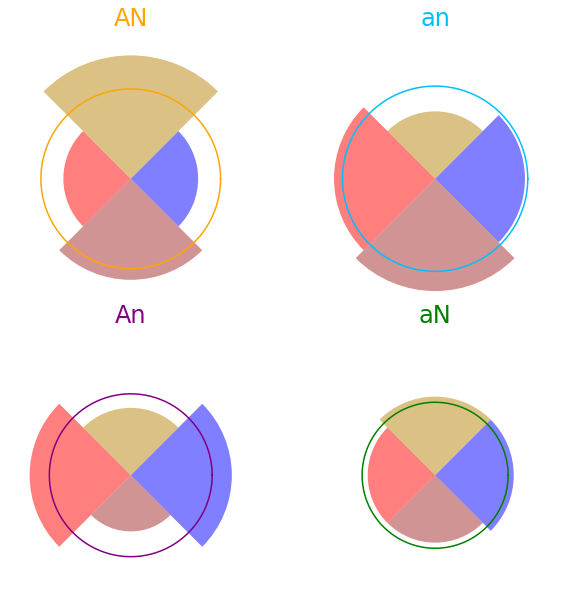

In [14]:
fig, axarr = plt.subplots(2, 2, figsize = (10, 10),
                          subplot_kw={'projection': 'polar'})
axlist = axarr.flatten()

rmax = 0.

for i, sto in enumerate(stories):
    tht = 2 * np.pi * np.arange(0, 1.01, 0.01)
    r = [len(story_dico[sto])/len(experiment) for j in tht]
    radii = []
    if len(experiment) == 4:
        theta = [0, np.pi/2, np.pi, -np.pi/2]
        width = [np.pi/2, np.pi/2, np.pi/2, np.pi/2]
    elif len(experiment) == 3:
        theta = [0, 2/3*np.pi, -2/3*np.pi]
        width = [2/3*np.pi, 2/3*np.pi, 2/3*np.pi]
    for j in range(len(experiment)):
        radii.append(len([x for x in story_dico[sto] if x >= j*len(ripf) and x < (j+1)*len(ripf)]))
    print(radii)
    rmax = max([rmax, max(radii)])

    colors = [clr_dico[e] for e in experiment]

    #ax = plt.subplot(projection='polar')
    axlist[i].bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)
    axlist[i].plot(tht, r, sto_colors[i])
    axlist[i].axis('off')
    axlist[i].set_title(sto, color = sto_colors[i])

for ax in axlist:
    ax.set_rmax(rmax)

plt.show()

In [15]:
raw_list = []
ano_list = []
for i in range(len(experiment)):
    for j in range(len(ripf)):
        raw_list.append(days.isel(experiment = i, ripf = j))
        ano_list.append(days_anomalies.isel(experiment = i, ripf = j))
story_days = xr.concat(raw_list, dim = pd.Index(np.arange(len(raw_list)), name = 'member')).drop(['experiment', 'ripf'])
story_days_anomalies = xr.concat(ano_list, dim = pd.Index(np.arange(len(ano_list)), name = 'member')).drop(['experiment', 'ripf'])

In [16]:
if season == 'JFM':
    sMon = 0
    eMon = 3

def is_season(month):
    return (month >= sMon) & (month <= eMon)

season_days = days.sel(time=is_season(days['time.month'])) - 273.15
season_days_anomalies = days_anomalies.sel(time=is_season(days['time.month']))
story_season_days = story_days.sel(time=is_season(days['time.month'])) - 273.15
story_season_days_anomalies = story_days_anomalies.sel(time=is_season(days['time.month']))

In [17]:
changes_save = pd.DataFrame({'rtrn_app': [], 'rtrn': [], 'rtrn_inf': [], 'rtrn_sup': [],
                             'ntns_app': [], 'ntns': [], 'ntns_inf': [], 'ntns_sup': [],
                             'new_ntns_app': [], 'new_ntns': [], 'new_ntns_inf': [], 'new_ntns_sup': []})

In [18]:
def plot_routine(days_ant, days_post, ano_days_ant, ano_days_post, extremum, indic, color='k', name = ['', '']):

    if extremum == 'min_ano':
        print(' Seasonnal min (anomaly)')
        max_or_min = 'min'
        days_ant_extr = ano_days_ant.groupby("time.year").min().values.flatten()
        days_post_extr = ano_days_post.groupby("time.year").min().values.flatten()
        sorted_days_ant = np.sort(days_ant_extr)[::-1]
        sorted_days_post = np.sort(days_post_extr)[::-1]
    elif extremum == 'min_raw':
        print(' Seasonnal min (raw)')
        max_or_min = 'min'
        days_ant_extr = days_ant.groupby("time.year").min().values.flatten()
        days_post_extr = days_post.groupby("time.year").min().values.flatten()
        sorted_days_ant = np.sort(days_ant_extr)[::-1]
        sorted_days_post = np.sort(days_post_extr)[::-1]
    elif extremum == 'max_ano':
        print(' Seasonnal max (anomaly)')
        max_or_min = 'max'
        days_ant_extr = ano_days_ant.groupby("time.year").max().values.flatten()
        days_post_extr = ano_days_post.groupby("time.year").max().values.flatten()
        sorted_days_ant = np.sort(days_ant_extr)
        sorted_days_post = np.sort(days_post_extr)
    elif extremum == 'max_raw':
        print(' Seasonnal max (raw)')
        max_or_min = 'max'
        days_ant_extr = days_ant.groupby("time.year").max().values.flatten()
        days_post_extr = days_post.groupby("time.year").max().values.flatten()
        sorted_days_ant = np.sort(days_ant_extr)
        sorted_days_post = np.sort(days_post_extr)

    print('   Raw estimations')
    rpci_raw = sorted_days_ant[int(len(days_ant_extr)*(1. - 1. / returnPeriod))]
    inv_rpci_raw = len(days_post_extr) / (len(days_post_extr) - (np.abs(sorted_days_post - rpci_raw)).argmin())
    rpci_raw_new = sorted_days_post[int(len(days_post_extr)*(1. - 1. / returnPeriod))]

    print('     Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci_raw))
    print('     New return period: {0:.2f}'.format(inv_rpci_raw), 'years')
    print('     New extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci_raw_new))

    print('   GEV estimations')
    gev = GEV(days_ant_extr, max_or_min = max_or_min)
    rpci = gev.rpci(returnPeriod)

    gev_new = GEV_change(gev, days_post_extr)
    rpci_new = gev_new.rpci(returnPeriod, new='new')
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('     Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))
    print('     New return period: {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))
    print('     New extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci_new[1]), '[{0:.2f} ;'.format(rpci_new[0]), '{0:.2f}]'.format(rpci_new[2]))

    chngs.loc[indic] = {'rtrn_app': inv_rpci_raw, 'rtrn': rpci_change[1], 'rtrn_inf': rpci_change[0], 'rtrn_sup': rpci_change[2],
                        'ntns_app': rpci_raw, 'ntns': rpci[1], 'ntns_inf': rpci[0], 'ntns_sup': rpci[2],
                        'new_ntns_app': rpci_raw_new, 'new_ntns': rpci_new[1], 'new_ntns_inf': rpci_new[0], 'new_ntns_sup': rpci_new[2],}

    if 'ano' in extremum:
        yLabel = 'anomaly of temperature'
    else:
        yLabel = 'temperature'

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.grid(True)
    ax.set_title(name)
    ax.set_xlabel('Return period')
    ax.set_ylabel('Return level of '+yLabel)

    gev._plot_rtrn(ax, colors = ['k', 'gray'], label = str(antStart)+'-'+str(antEnd))
    gev_new._plot_rtrn(ax, colors = [color, color], label = str(postStart)+'-'+str(postEnd), new = True)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.grid(True)
    ax.set_title(name)
    ax.set_xlabel('Return period')
    ax.set_ylabel('Return level of '+yLabel)

    plt.axhline(y=rpci_raw, color='gray', linestyle=':')
    plt.axvline(x=inv_rpci_raw, color='gray', linestyle=':')

    gev._plot_rtrn(ax, colors = ['k', 'gray'], label = str(antStart)+'-'+str(antEnd))
    gev_new._plot_ntns(ax, colors = [color, color], label = str(postStart)+'-'+str(postEnd), new=True)

    plt.axhline(y=rpci[1], color='gray', linestyle='--')
    plt.axvline(x=rpci_change[0], color='gray', linestyle='--')
    plt.axvline(x=rpci_change[1], color='gray', linestyle='--')
    plt.axvline(x=rpci_change[2], color='gray', linestyle='--')

    ax.plot([inv_rpci_raw, returnPeriod], [rpci_raw, rpci_raw], 'o-k')
    ax.plot([rpci_change[0], returnPeriod], [rpci[0], rpci[0]], 'P-k')
    ax.plot([rpci_change[1], returnPeriod], [rpci[1], rpci[1]], 'P-k')
    ax.plot([rpci_change[2], returnPeriod], [rpci[2], rpci[2]], 'P-k')

    if extremum == 'min_ano':
        plt.xlim(8, 80)
        plt.ylim(-17, -9)
        plt.ylim(-12.5, -10)
    elif extremum == 'min_raw':
        plt.xlim(8, 80)
        plt.ylim(-21, -18)
    elif extremum == 'max_ano':
        plt.xlim(2, 20)
        plt.ylim(6, 11)

    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))

    plt.show()

Experiment: hist-ssp126
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.47
     New return period: 28.57 years
     New extreme warm event associated with a return period of 10 years: -10.25
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -11.61 [-11.28 ; -11.94]
     New return period: 26.46 years [20.48 ; 34.89]
     New extreme warm event associated with a return period of 10 years: -10.22 [-9.98 ; -10.46]


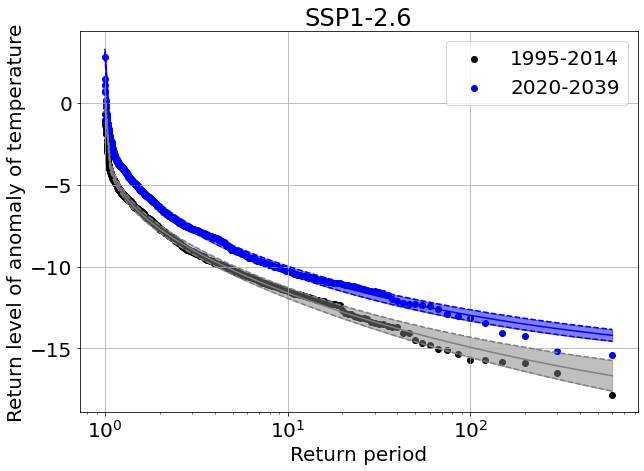

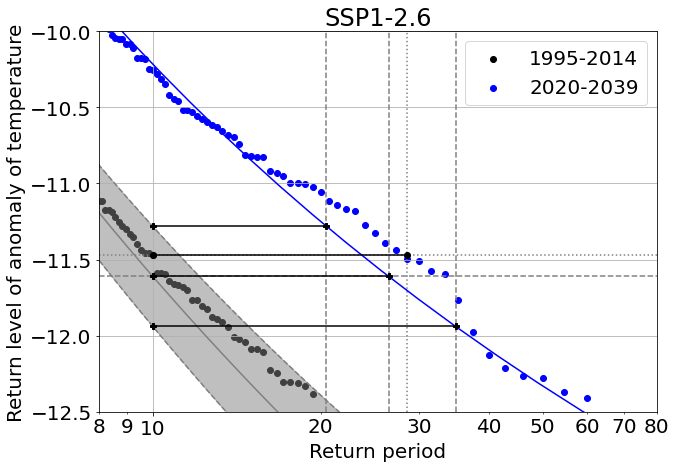

Experiment: hist-ssp245
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.47
     New return period: 20.00 years
     New extreme warm event associated with a return period of 10 years: -10.35
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -11.61 [-11.28 ; -11.94]
     New return period: 21.88 years [17.87 ; 27.01]
     New extreme warm event associated with a return period of 10 years: -10.25 [-9.89 ; -10.61]


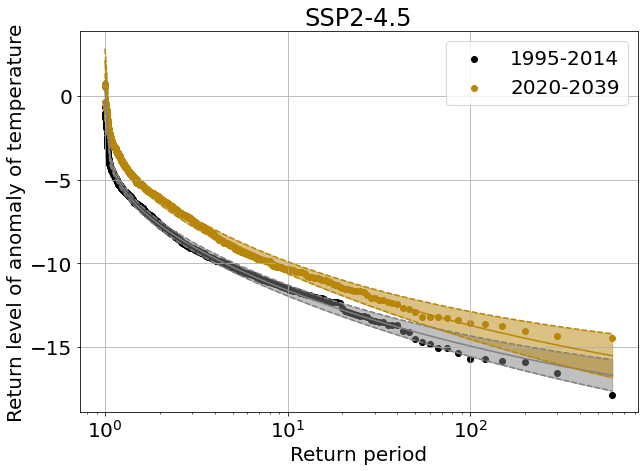

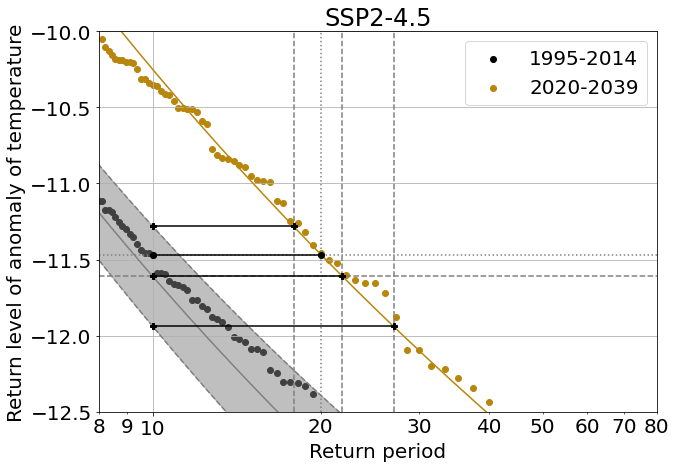

Experiment: hist-ssp370
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.47
     New return period: 14.63 years
     New extreme warm event associated with a return period of 10 years: -10.77
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -11.61 [-11.28 ; -11.94]
     New return period: 16.20 years [13.31 ; 19.93]
     New extreme warm event associated with a return period of 10 years: -10.77 [-10.43 ; -11.11]


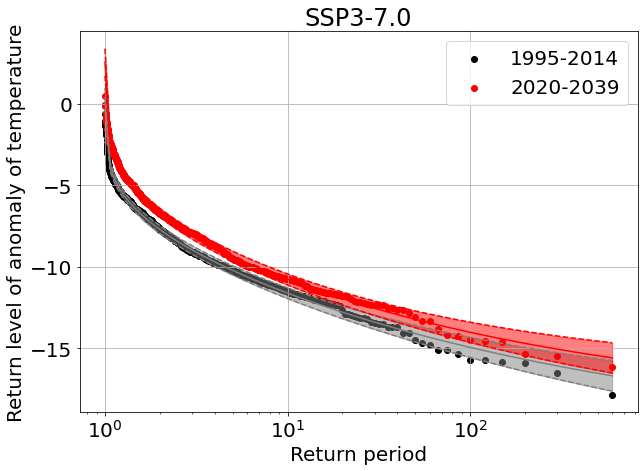

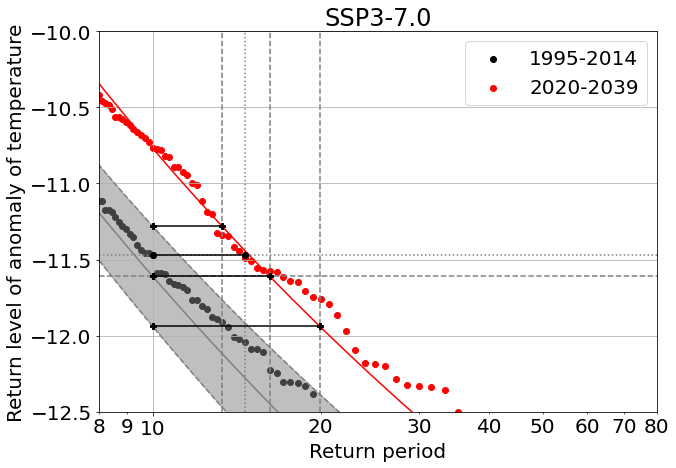

Experiment: hist-ssp585
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.47
     New return period: 25.00 years
     New extreme warm event associated with a return period of 10 years: -9.96
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -11.61 [-11.28 ; -11.94]
     New return period: 27.14 years [21.45 ; 34.84]
     New extreme warm event associated with a return period of 10 years: -10.06 [-9.75 ; -10.38]


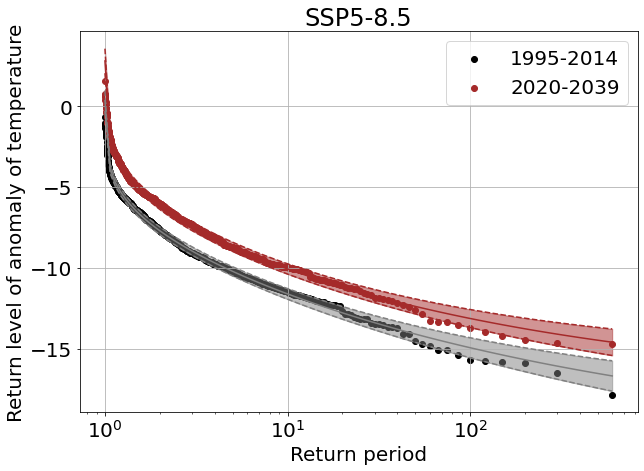

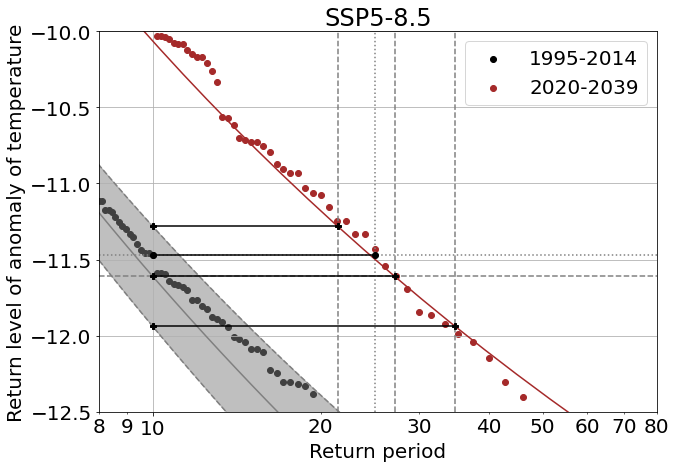

Story: AN
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.01
     New return period: 53.33 years
     New extreme warm event associated with a return period of 10 years: -9.15
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


     Extreme warm event associated with a return period of 10 years: -11.23 [-10.94 ; -11.51]
     New return period: 48.97 years [38.47 ; 63.24]
     New extreme warm event associated with a return period of 10 years: -9.00 [-8.74 ; -9.27]


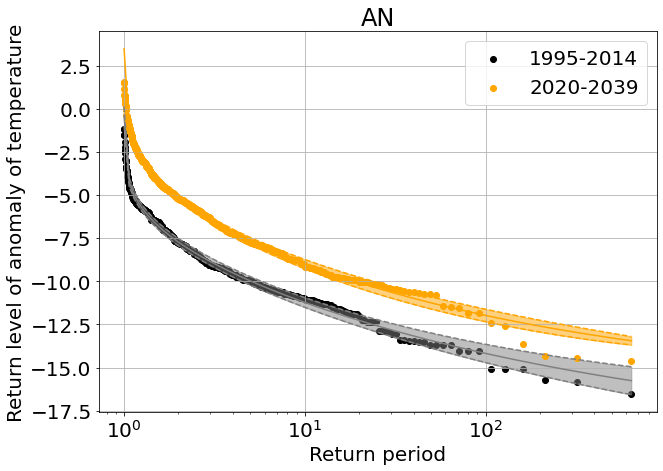

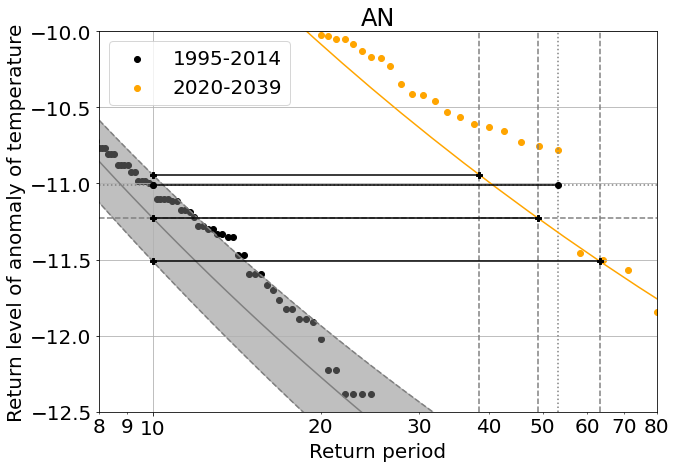

Story: an
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.68
     New return period: 17.37 years
     New extreme warm event associated with a return period of 10 years: -10.93
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


     Extreme warm event associated with a return period of 10 years: -11.73 [-11.41 ; -12.05]
     New return period: 15.66 years [12.73 ; 19.51]
     New extreme warm event associated with a return period of 10 years: -11.02 [-10.73 ; -11.31]


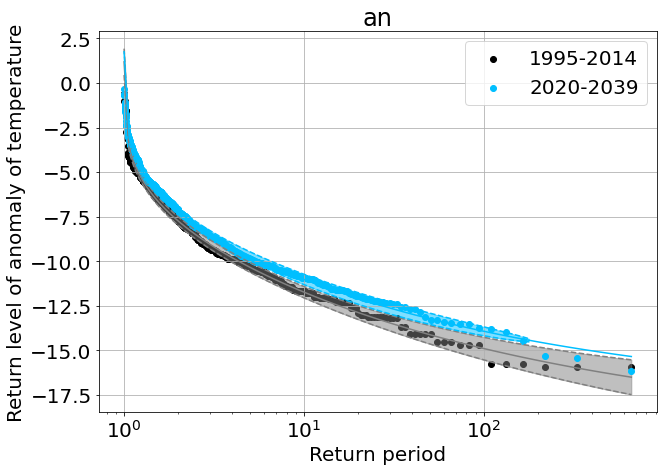

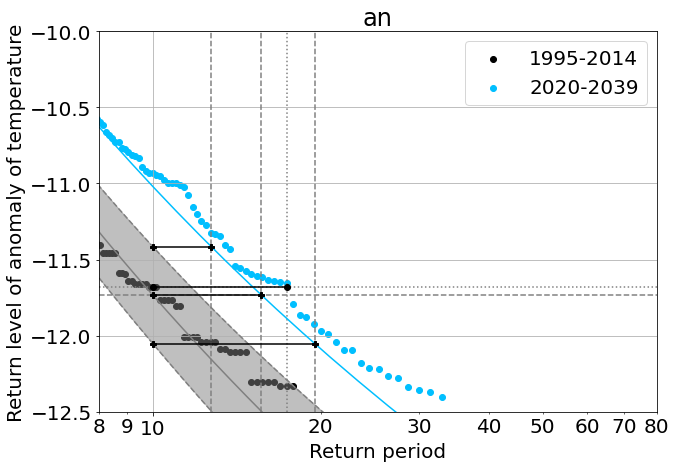

Story: An
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.82
     New return period: 26.36 years
     New extreme warm event associated with a return period of 10 years: -10.31
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -11.73 [-11.30 ; -12.15]
     New return period: 25.36 years [19.00 ; 34.54]
     New extreme warm event associated with a return period of 10 years: -10.24 [-9.91 ; -10.56]


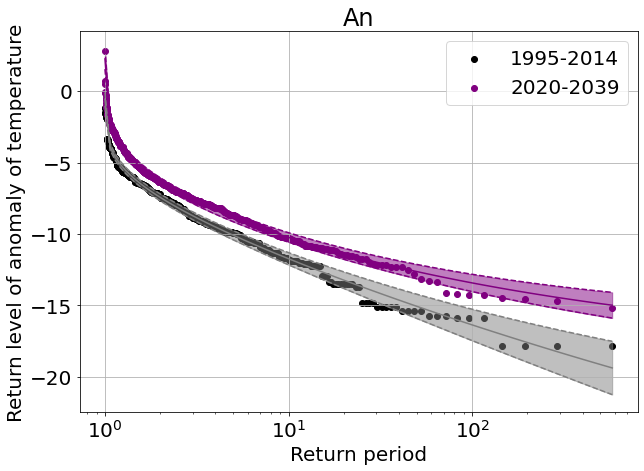

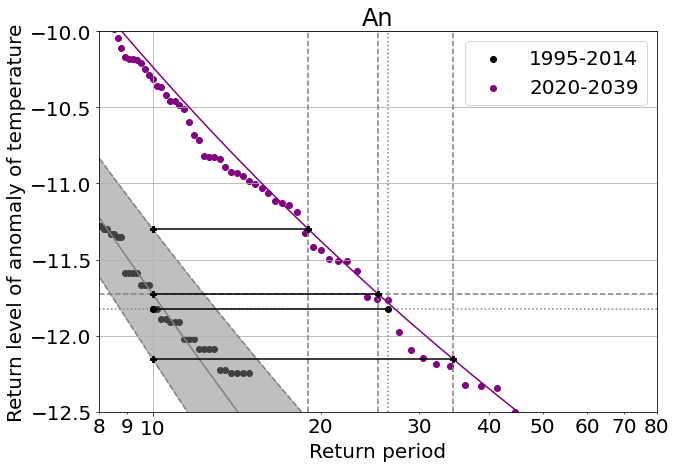

Story: aN
 Seasonnal min (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -11.59
     New return period: 19.26 years
     New extreme warm event associated with a return period of 10 years: -10.74
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -11.70 [-11.49 ; -11.91]
     New return period: 18.66 years [16.40 ; 21.31]
     New extreme warm event associated with a return period of 10 years: -10.62 [-10.24 ; -11.00]


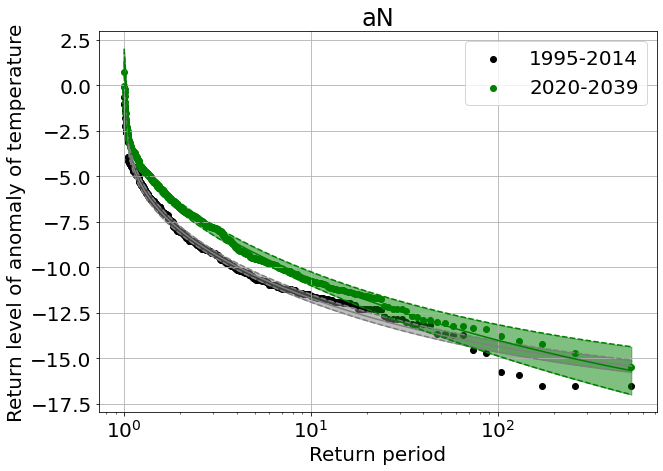

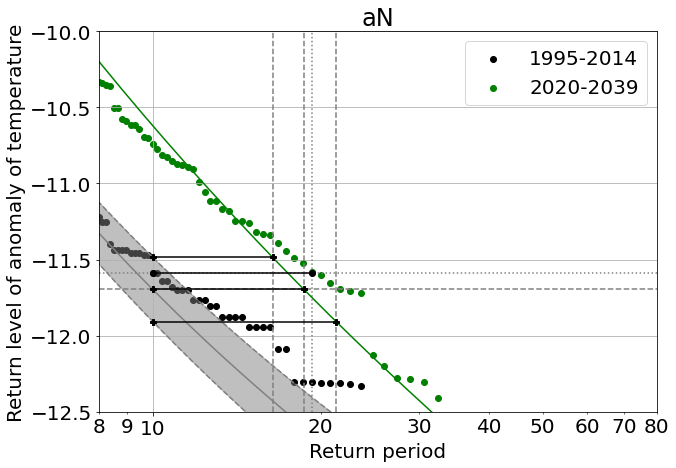


Experiment: hist-ssp126
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.49
     New return period: 4.14 years
     New extreme warm event associated with a return period of 10 years: 9.56
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


     Extreme warm event associated with a return period of 10 years: 8.56 [nan ; nan]
     New return period: 3.87 years [nan ; nan]
     New extreme warm event associated with a return period of 10 years: 9.53 [9.39 ; 9.68]


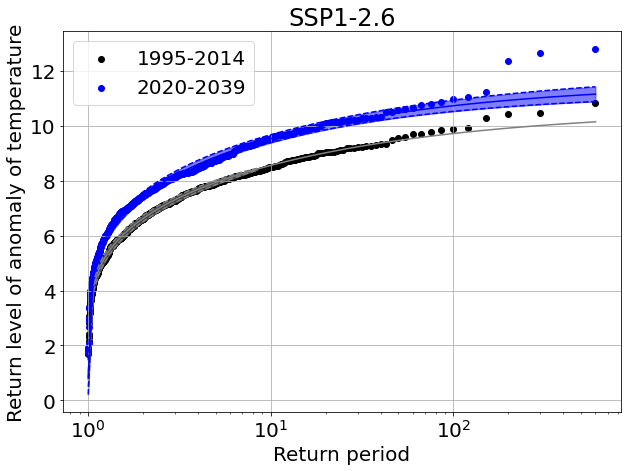

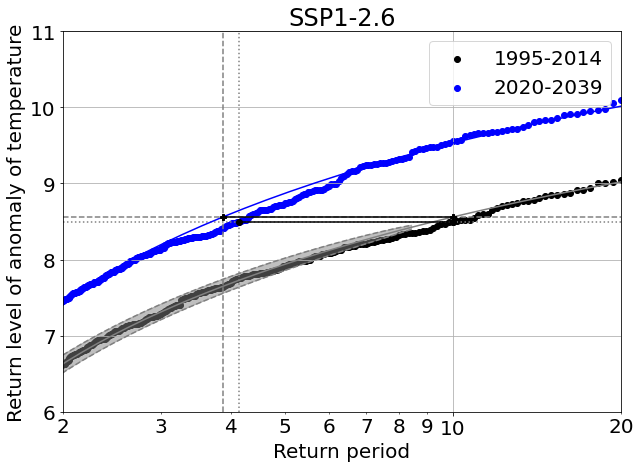

Experiment: hist-ssp245
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.49
     New return period: 3.90 years
     New extreme warm event associated with a return period of 10 years: 9.54
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 8.56 [nan ; nan]
     New return period: 3.86 years [nan ; nan]
     New extreme warm event associated with a return period of 10 years: 9.51 [nan ; nan]


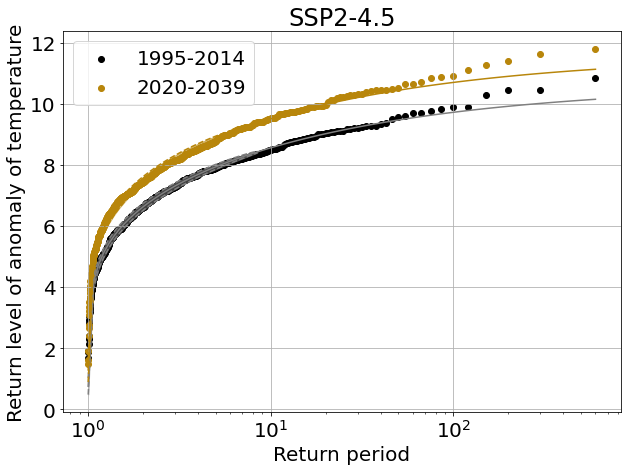

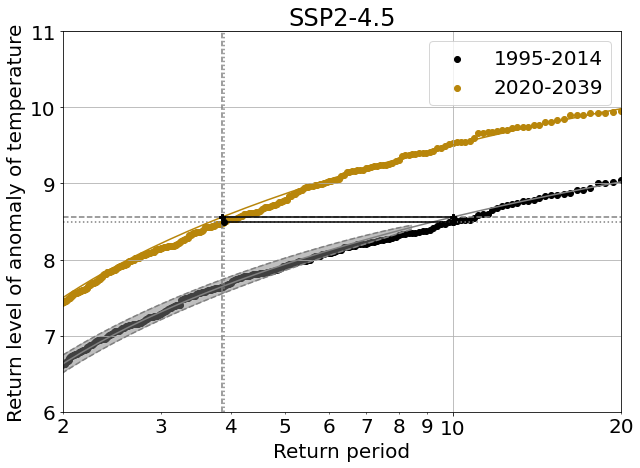

Experiment: hist-ssp370
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.49
     New return period: 4.51 years
     New extreme warm event associated with a return period of 10 years: 9.25
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 8.56 [nan ; nan]
     New return period: 4.63 years [nan ; nan]
     New extreme warm event associated with a return period of 10 years: 9.26 [9.11 ; 9.42]


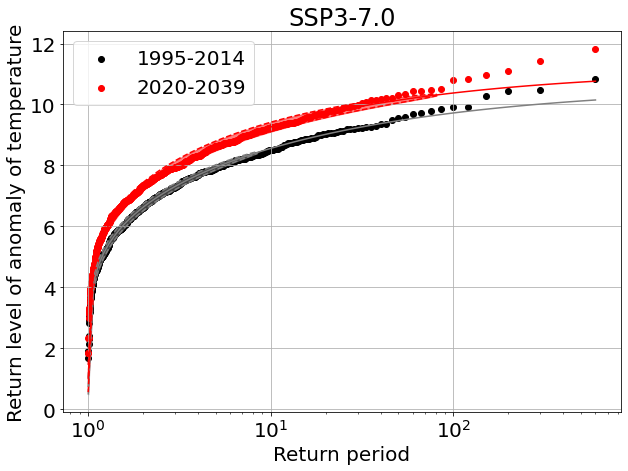

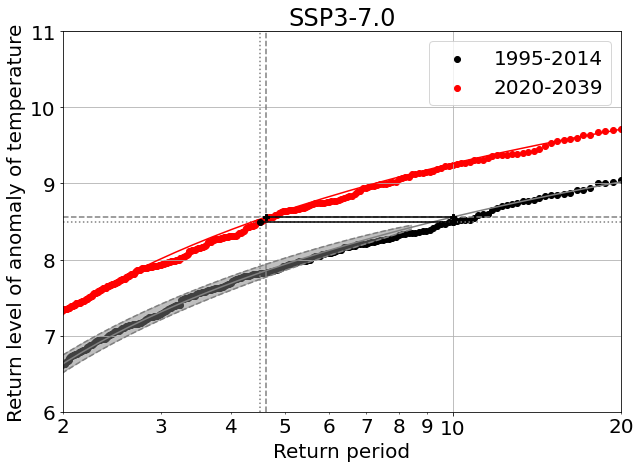

Experiment: hist-ssp585
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.49
     New return period: 3.80 years
     New extreme warm event associated with a return period of 10 years: 9.61
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


     Extreme warm event associated with a return period of 10 years: 8.56 [nan ; nan]
     New return period: 3.87 years [nan ; nan]
     New extreme warm event associated with a return period of 10 years: 9.57 [9.51 ; 9.63]


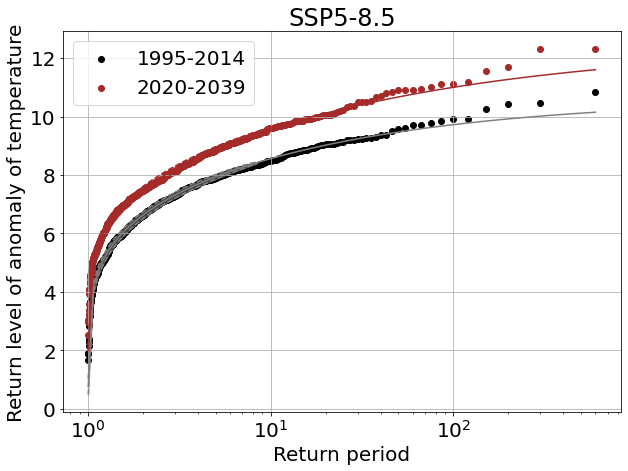

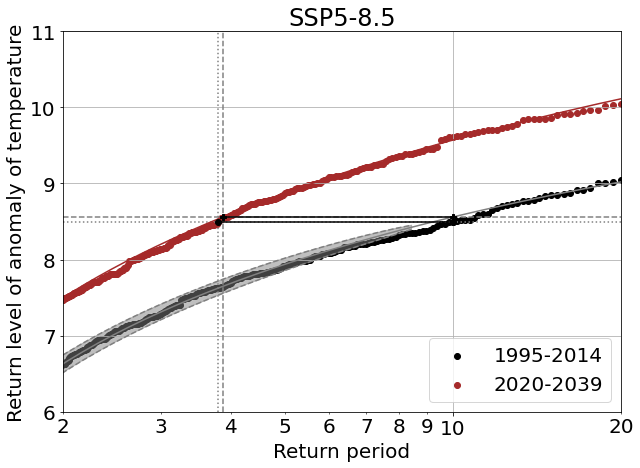

Story: AN
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.71
     New return period: 2.86 years
     New extreme warm event associated with a return period of 10 years: 9.93
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 8.78 [8.74 ; 8.83]
     New return period: 2.97 years [2.87 ; 3.08]
     New extreme warm event associated with a return period of 10 years: 10.01 [9.89 ; 10.14]


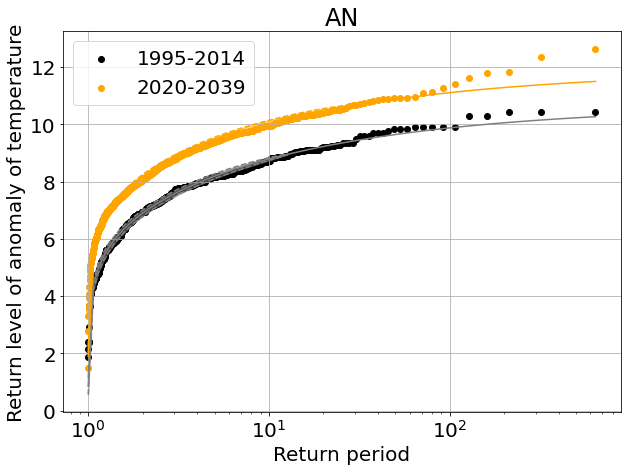

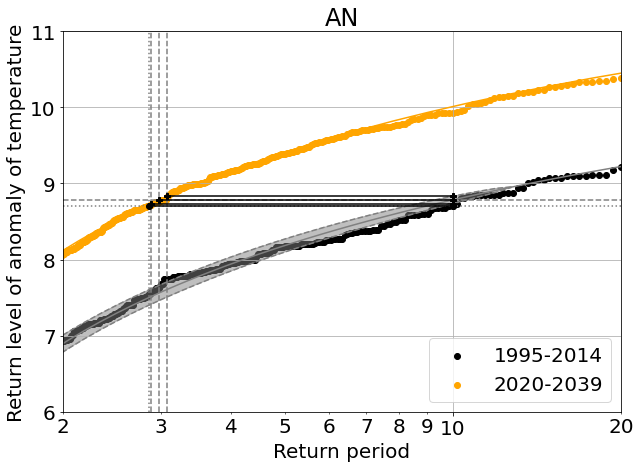

Story: an
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.30
     New return period: 5.37 years
     New extreme warm event associated with a return period of 10 years: 8.88
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 8.42 [8.30 ; 8.53]
     New return period: 5.51 years [4.98 ; 6.12]
     New extreme warm event associated with a return period of 10 years: 8.99 [nan ; nan]


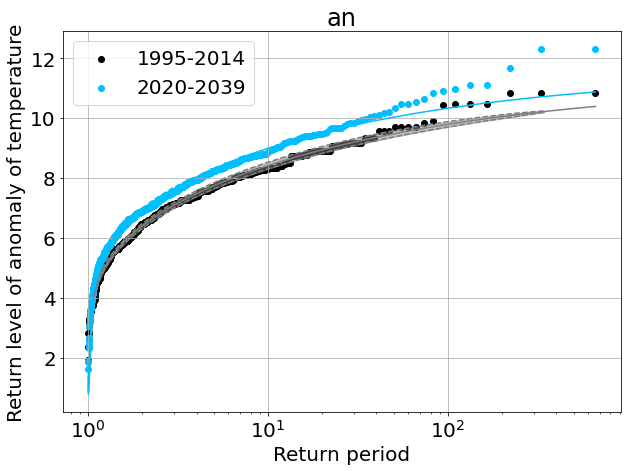

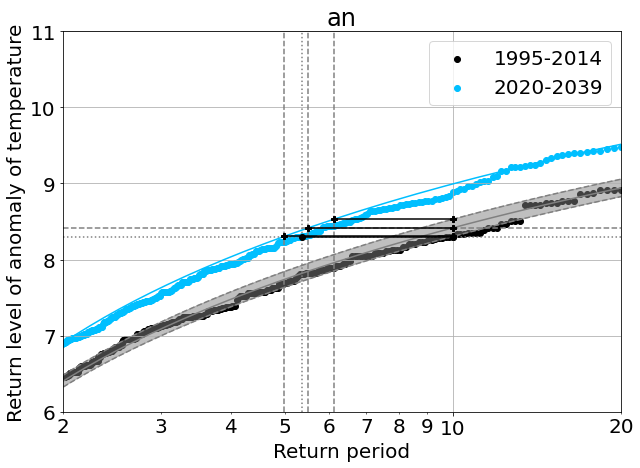

Story: An
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.38
     New return period: 3.95 years
     New extreme warm event associated with a return period of 10 years: 9.46
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 8.42 [8.25 ; 8.59]
     New return period: 3.70 years [3.27 ; 4.23]
     New extreme warm event associated with a return period of 10 years: 9.46 [9.34 ; 9.58]


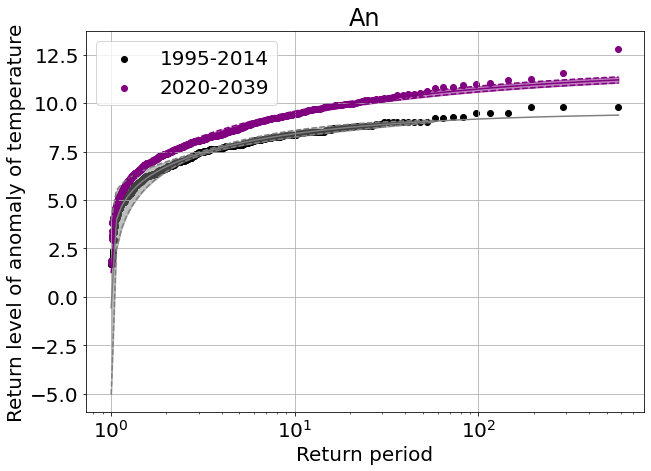

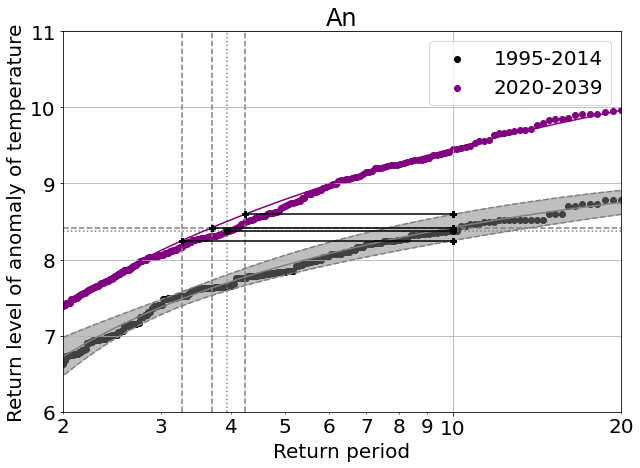

Story: aN
 Seasonnal max (anomaly)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 8.54
     New return period: 5.84 years
     New extreme warm event associated with a return period of 10 years: 8.96
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 8.52 [8.35 ; 8.70]
     New return period: 5.12 years [4.25 ; 6.31]
     New extreme warm event associated with a return period of 10 years: 9.02 [nan ; nan]


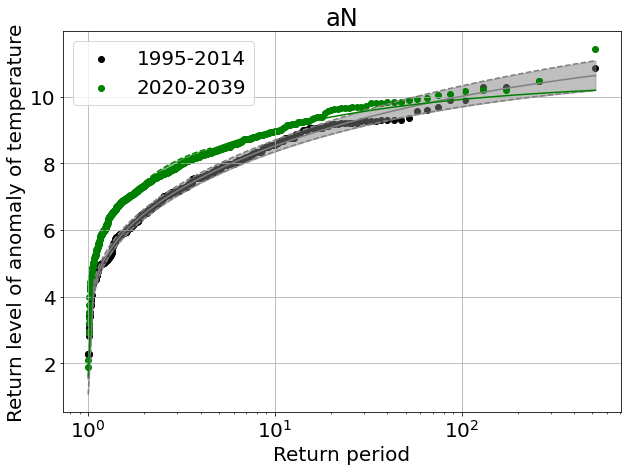

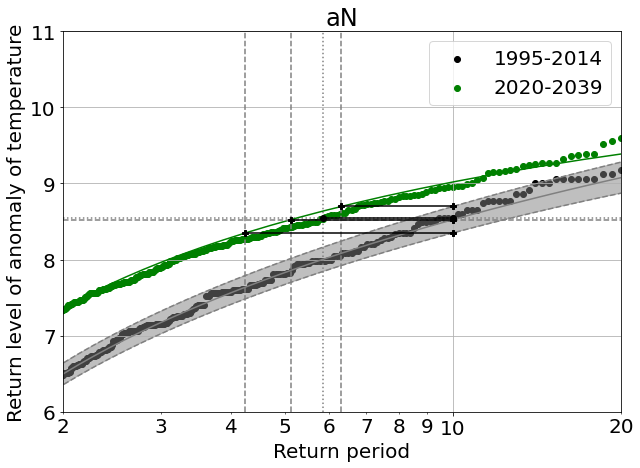


Experiment: hist-ssp126
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -19.04
     New return period: 31.58 years
     New extreme warm event associated with a return period of 10 years: -17.33
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -19.22 [-18.93 ; -19.52]
     New return period: 39.53 years [30.52 ; 52.30]
     New extreme warm event associated with a return period of 10 years: -17.35 [-17.05 ; -17.65]


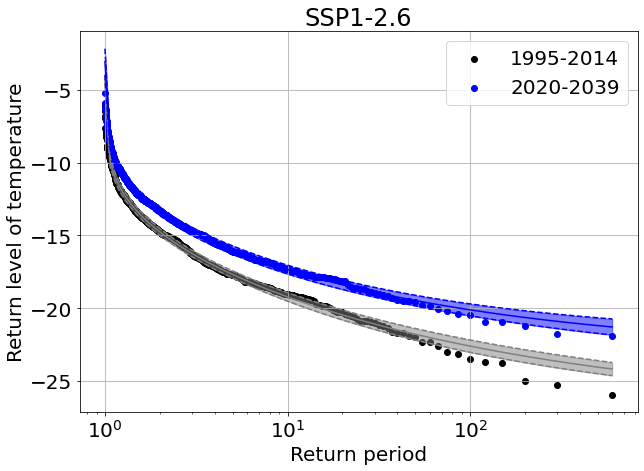

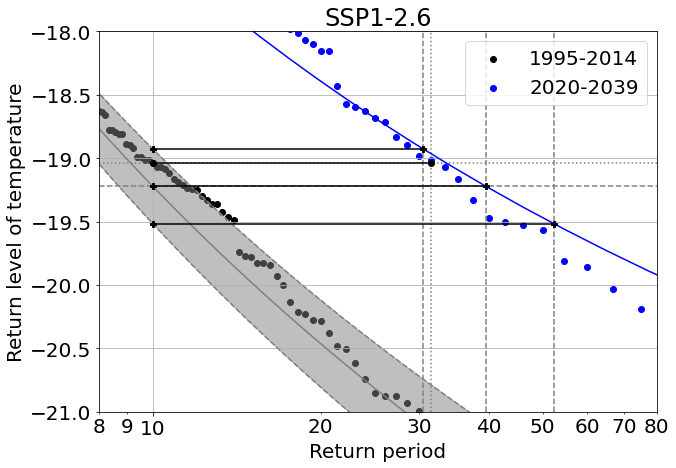

Experiment: hist-ssp245
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -19.04
     New return period: 26.09 years
     New extreme warm event associated with a return period of 10 years: -17.28
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -19.22 [-18.93 ; -19.52]
     New return period: 30.66 years [25.52 ; 37.09]
     New extreme warm event associated with a return period of 10 years: -17.25 [-16.88 ; -17.62]


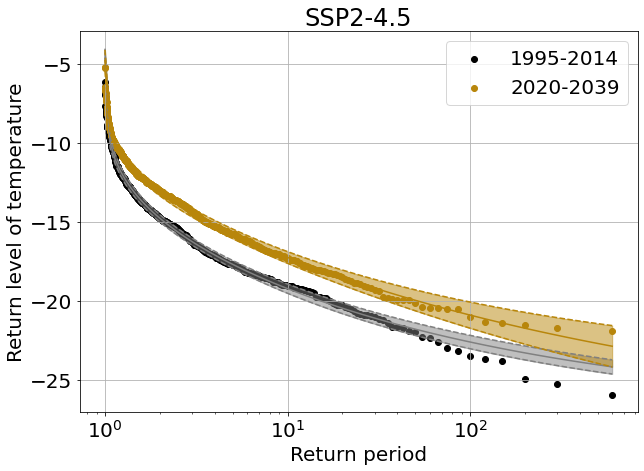

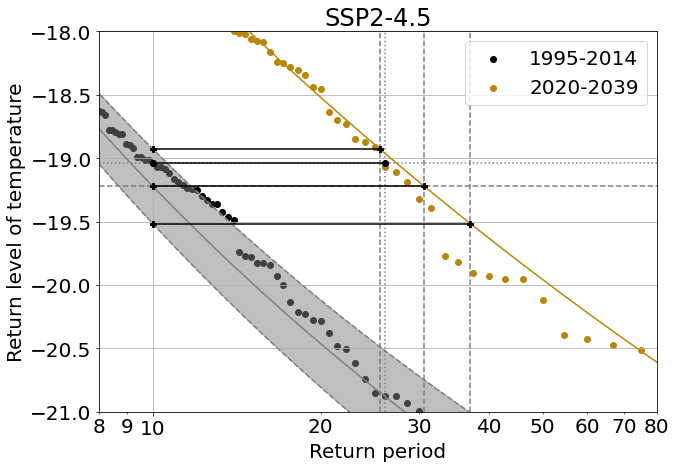

Experiment: hist-ssp370
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -19.04
     New return period: 18.75 years
     New extreme warm event associated with a return period of 10 years: -17.85
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -19.22 [-18.93 ; -19.52]
     New return period: 21.72 years [18.10 ; 26.29]
     New extreme warm event associated with a return period of 10 years: -17.87 [-17.52 ; -18.21]


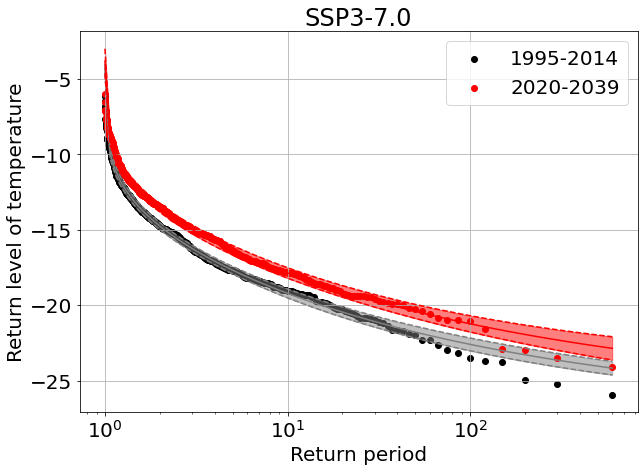

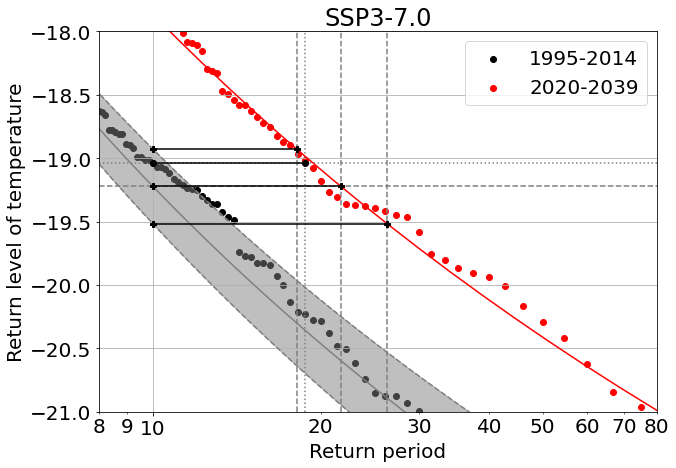

Experiment: hist-ssp585
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -19.04
     New return period: 28.57 years
     New extreme warm event associated with a return period of 10 years: -17.33
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -19.22 [-18.93 ; -19.52]
     New return period: 32.18 years [26.85 ; 38.81]
     New extreme warm event associated with a return period of 10 years: -17.11 [-16.74 ; -17.49]


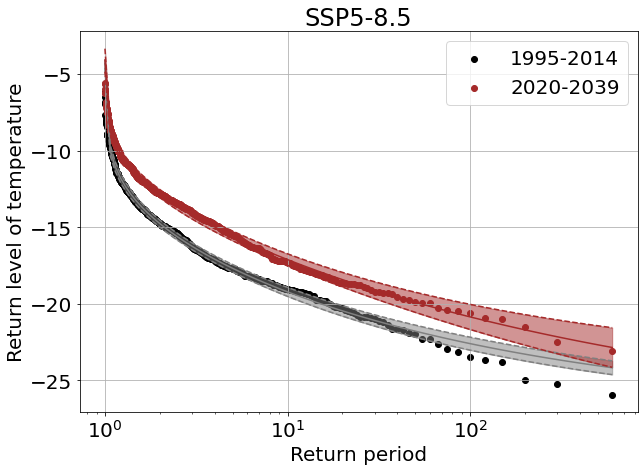

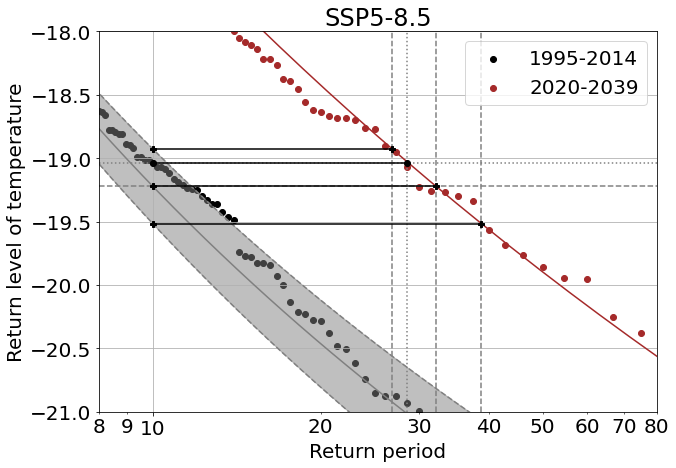

Story: AN
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -19.21
     New return period: 40.00 years
     New extreme warm event associated with a return period of 10 years: -16.77
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


     Extreme warm event associated with a return period of 10 years: -19.51 [-19.17 ; -19.84]
     New return period: 69.78 years [51.59 ; 96.74]
     New extreme warm event associated with a return period of 10 years: -16.81 [nan ; nan]


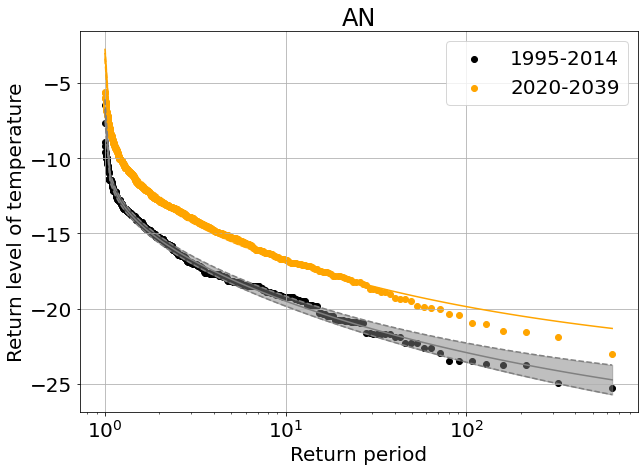

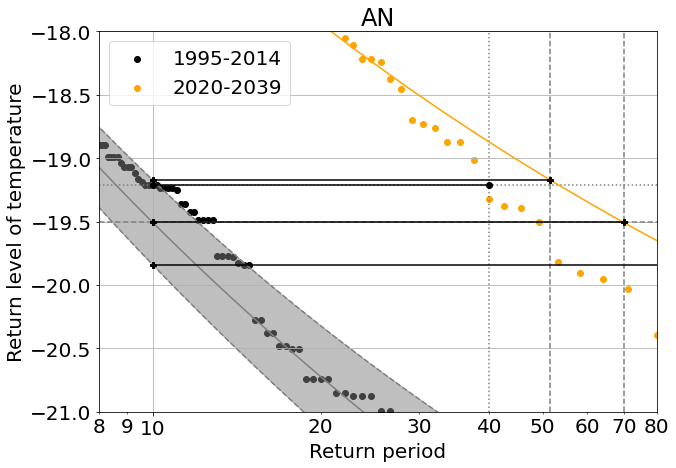

Story: an
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -18.81
     New return period: 17.37 years
     New extreme warm event associated with a return period of 10 years: -17.82
   GEV estimations
     Extreme warm event associated with a return period of 10 years: -18.87 [-18.52 ; -19.22]
     New return period: 17.72 years [14.57 ; 21.74]
     New extreme warm event associated with a return period of 10 years: -17.80 [-17.43 ; -18.17]


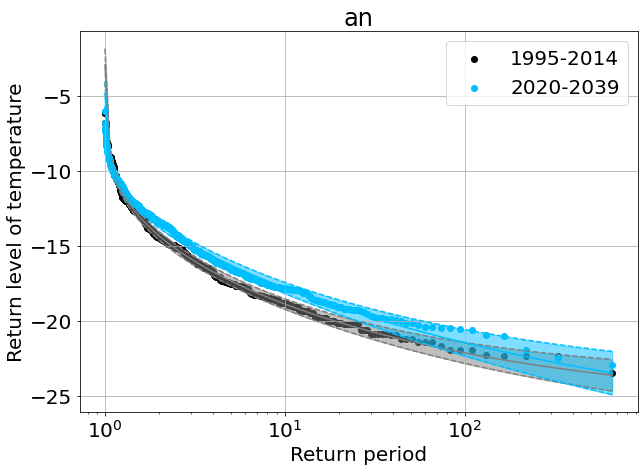

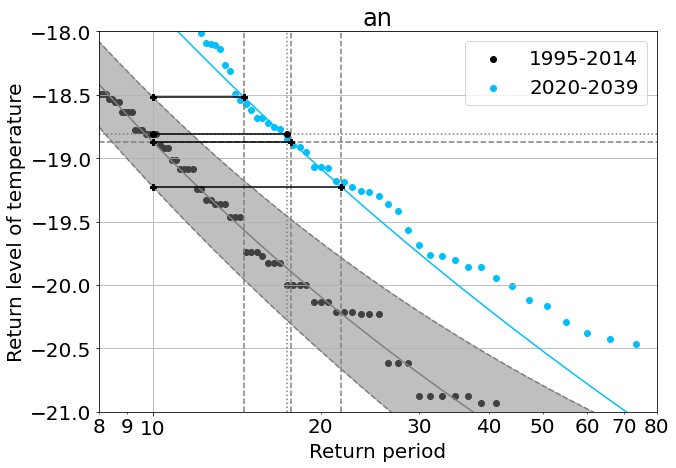

Story: An
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -19.04
     New return period: 25.22 years
     New extreme warm event associated with a return period of 10 years: -17.28
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


     Extreme warm event associated with a return period of 10 years: -19.23 [-18.77 ; -19.69]
     New return period: 32.87 years [23.77 ; 46.77]
     New extreme warm event associated with a return period of 10 years: -17.33 [-17.02 ; -17.64]


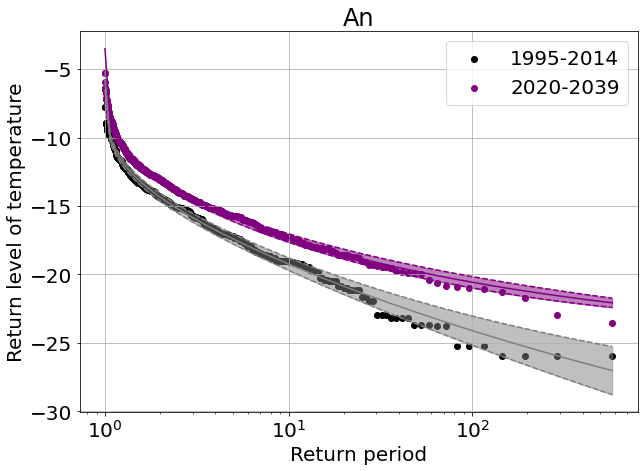

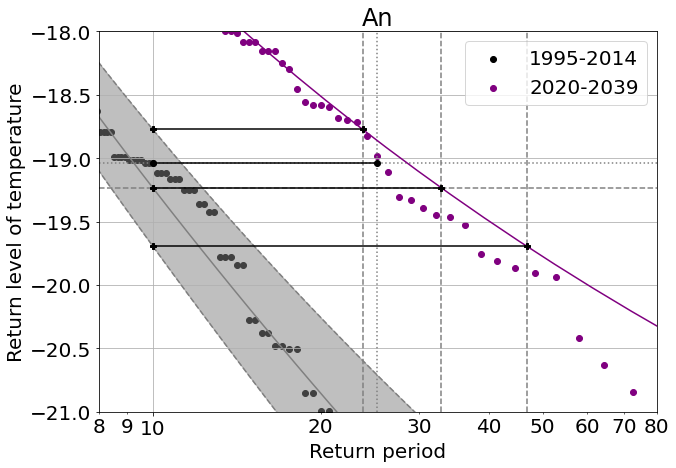

Story: aN
 Seasonnal min (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: -18.92
     New return period: 21.67 years
     New extreme warm event associated with a return period of 10 years: -17.77
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: -19.07 [-18.73 ; -19.42]
     New return period: 22.41 years [18.27 ; 27.75]
     New extreme warm event associated with a return period of 10 years: -17.63 [-17.24 ; -18.02]


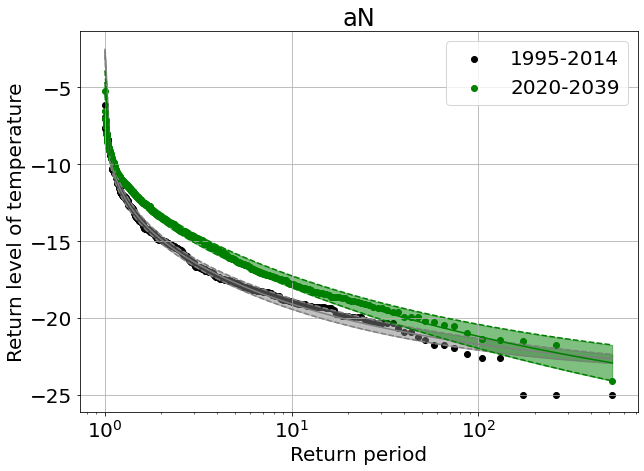

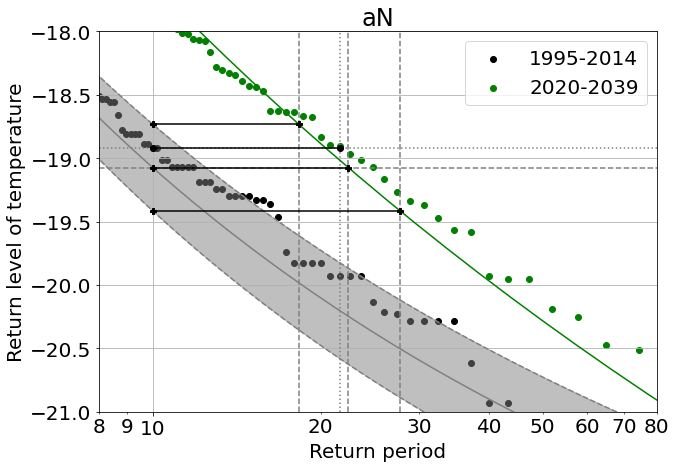


Experiment: hist-ssp126
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.64
     New return period: 5.45 years
     New extreme warm event associated with a return period of 10 years: 4.16
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.68 [3.33 ; 4.03]
     New return period: 5.42 years [3.99 ; 7.79]
     New extreme warm event associated with a return period of 10 years: 4.24 [nan ; nan]


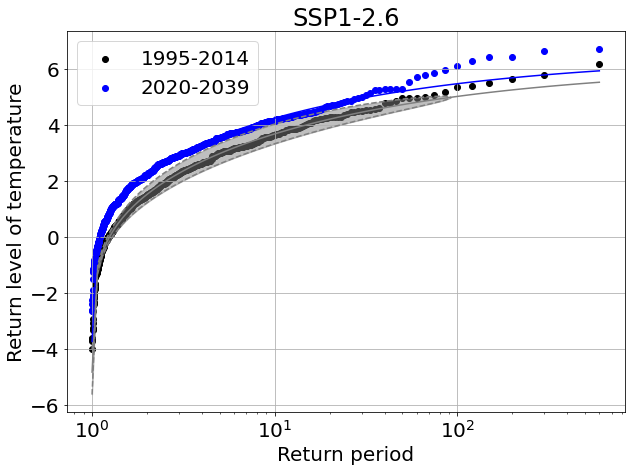

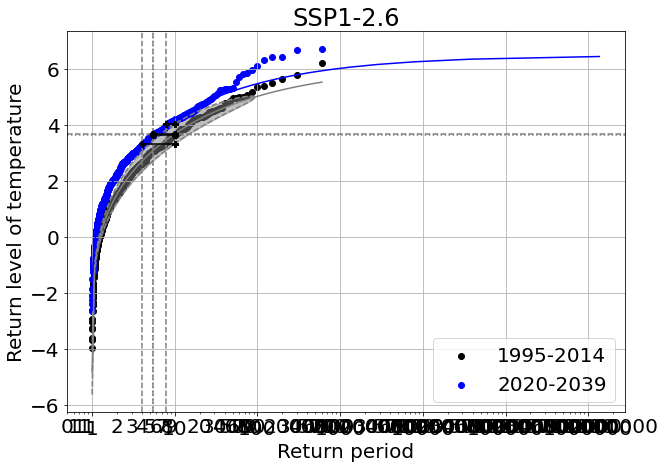

Experiment: hist-ssp245
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.64
     New return period: 5.61 years
     New extreme warm event associated with a return period of 10 years: 4.28
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.68 [3.33 ; 4.03]
     New return period: 5.26 years [3.91 ; 7.43]
     New extreme warm event associated with a return period of 10 years: 4.30 [4.24 ; 4.35]


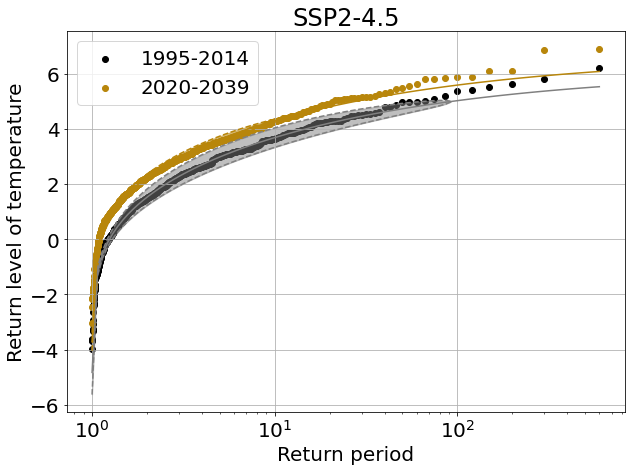

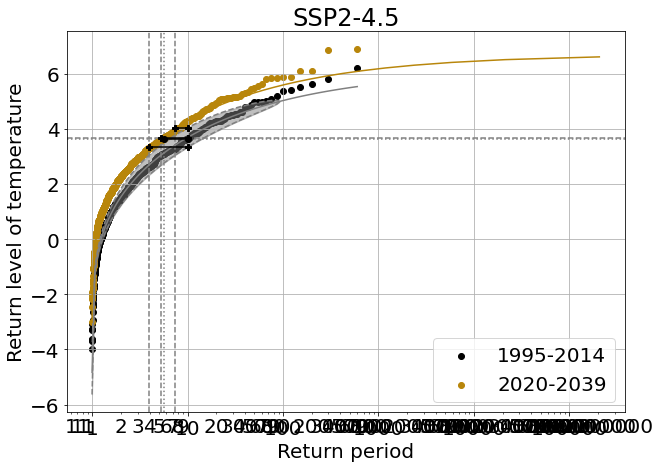

Experiment: hist-ssp370
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.64
     New return period: 6.82 years
     New extreme warm event associated with a return period of 10 years: 4.02
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/softs/anaconda3/envs/gloenv/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/data/softs/anaconda3/envs/gloenv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


     Extreme warm event associated with a return period of 10 years: 3.68 [3.33 ; 4.03]
     New return period: 6.30 years [4.66 ; 8.91]
     New extreme warm event associated with a return period of 10 years: 4.14 [3.81 ; 4.47]


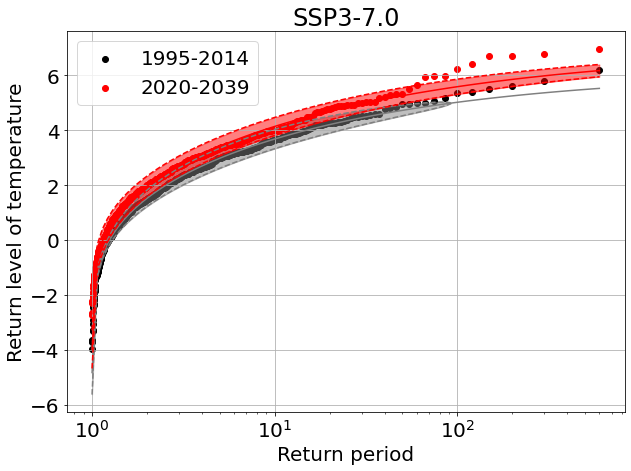

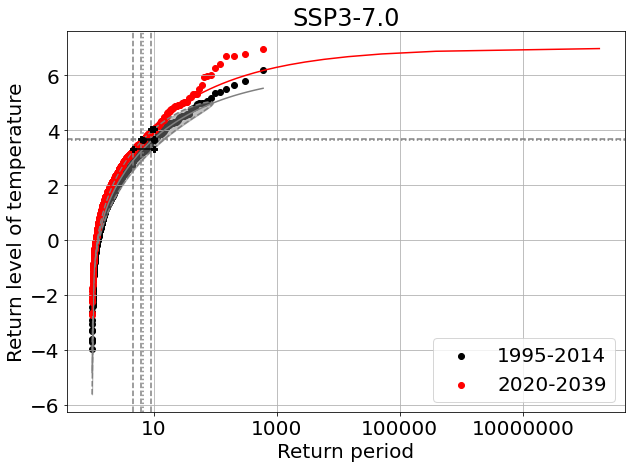

Experiment: hist-ssp585
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.64
     New return period: 5.26 years
     New extreme warm event associated with a return period of 10 years: 4.16
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.68 [3.33 ; 4.03]
     New return period: 5.21 years [3.82 ; 7.54]
     New extreme warm event associated with a return period of 10 years: 4.27 [4.07 ; 4.46]


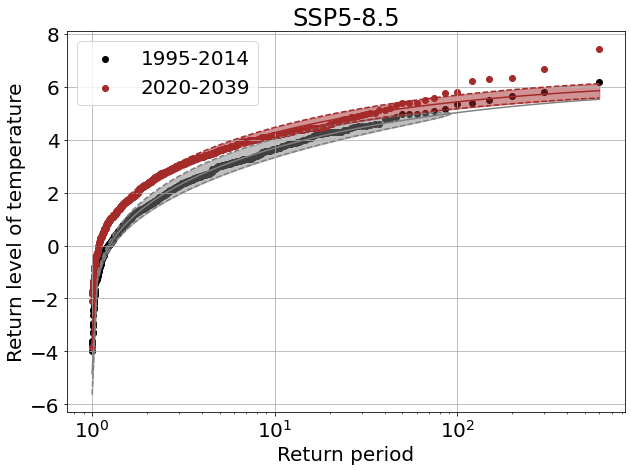

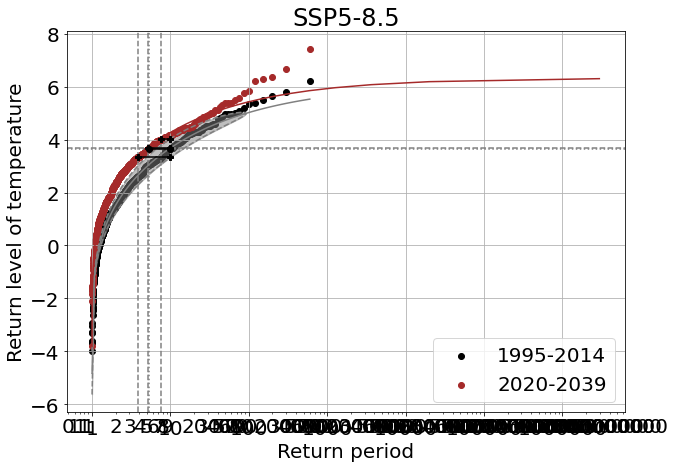

Story: AN
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.36
     New return period: 3.64 years
     New extreme warm event associated with a return period of 10 years: 4.27
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.39 [3.25 ; 3.52]
     New return period: 3.77 years [3.40 ; 4.19]
     New extreme warm event associated with a return period of 10 years: 4.39 [nan ; nan]


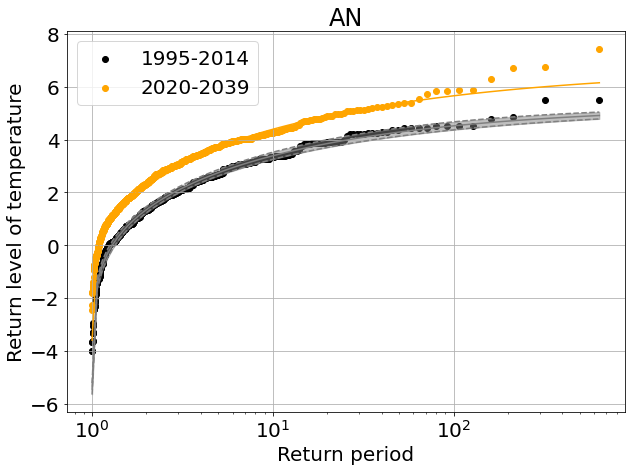

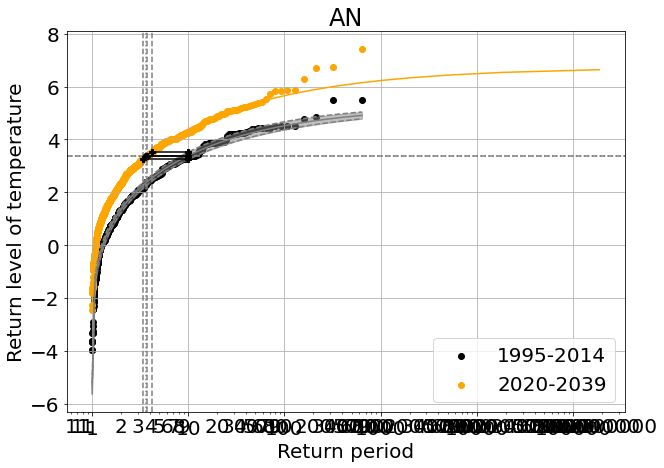

Story: an
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.97
     New return period: 9.71 years
     New extreme warm event associated with a return period of 10 years: 3.98
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.90 [3.74 ; 4.06]
     New return period: 7.92 years [6.69 ; 9.49]
     New extreme warm event associated with a return period of 10 years: 4.11 [4.05 ; 4.17]


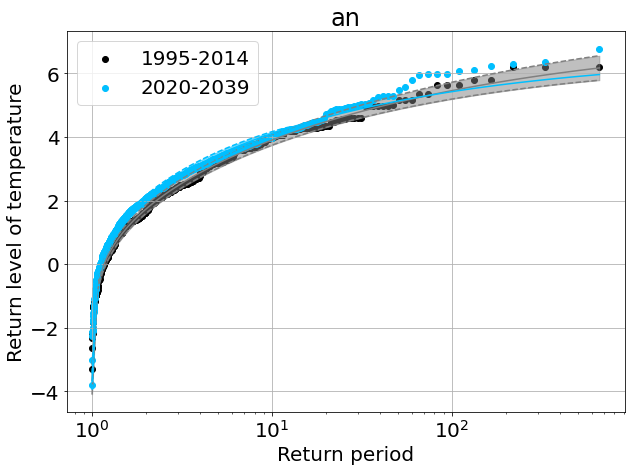

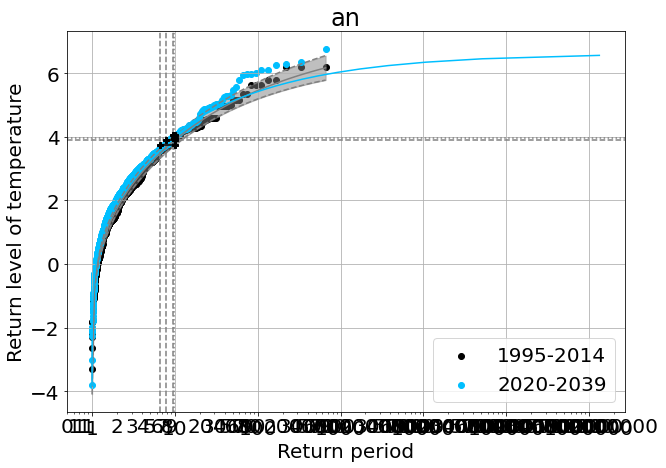

Story: An
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.43
     New return period: 4.68 years
     New extreme warm event associated with a return period of 10 years: 4.25
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.55 [3.42 ; 3.67]
     New return period: 4.71 years [4.23 ; 5.29]
     New extreme warm event associated with a return period of 10 years: 4.25 [4.11 ; 4.40]


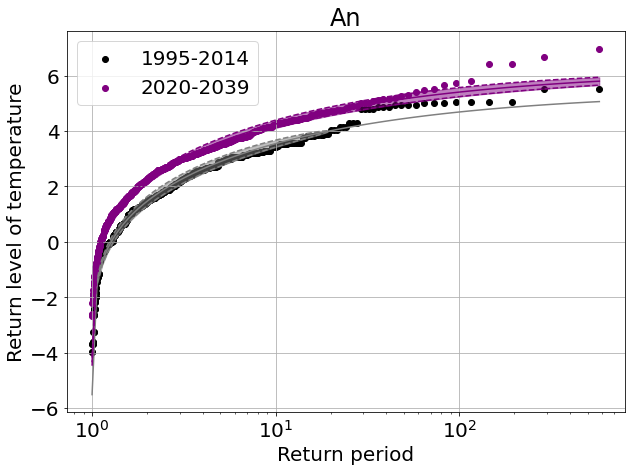

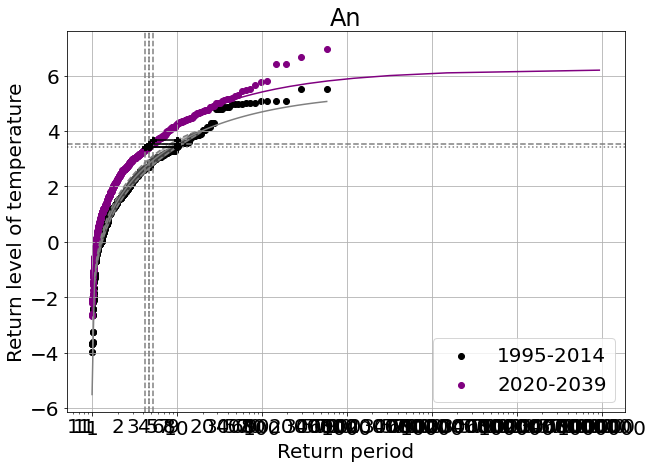

Story: aN
 Seasonnal max (raw)
   Raw estimations
     Extreme warm event associated with a return period of 10 years: 3.77
     New return period: 7.32 years
     New extreme warm event associated with a return period of 10 years: 4.06
   GEV estimations


/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt
/data/scratch/globc/line/Python36/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in double_scalars


     Extreme warm event associated with a return period of 10 years: 3.85 [3.66 ; 4.04]
     New return period: 6.89 years [5.72 ; 8.43]
     New extreme warm event associated with a return period of 10 years: 4.19 [4.00 ; 4.38]


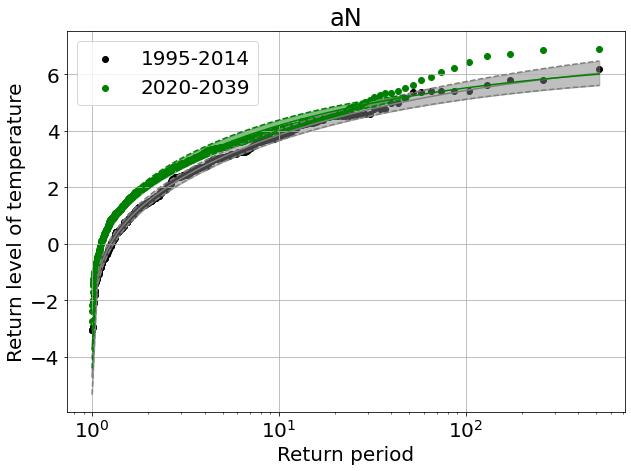

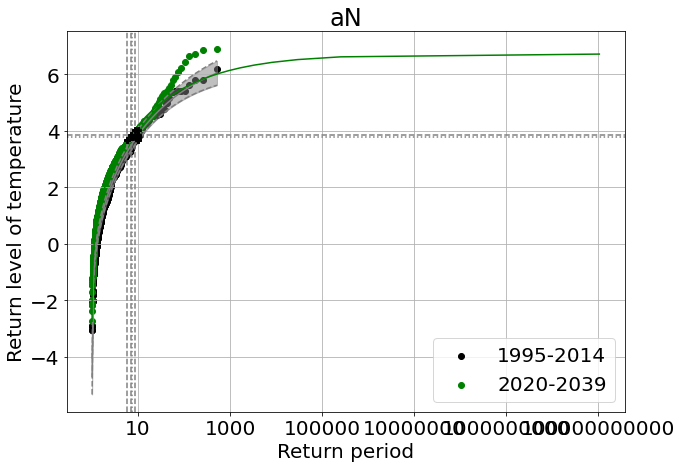

In [19]:
changes_save_list = []

for extremum in extrema:
    
    chngs = changes_save.copy(deep=True)

    for i, e in enumerate(experiment):
        print('Experiment:', e)
        days_ant = season_days.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
        days_post = season_days.sel(experiment = e, time = slice(str(postStart), str(postEnd)))
        ano_days_ant = season_days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
        ano_days_post = season_days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

        plot_routine(days_ant, days_post, ano_days_ant, ano_days_post, extremum, indic = e, color = clr_dico[e], name = exp_dico[e])

    for i, s in enumerate(stories):
        print('Story:', s)
        days_ant = story_season_days.sel(member = story_dico[s], time = slice(str(antStart), str(antEnd)))
        days_post = story_season_days.sel(member = story_dico[s], time = slice(str(postStart), str(postEnd)))
        ano_days_ant = story_season_days_anomalies.sel(member = story_dico[s], time = slice(str(antStart), str(antEnd)))
        ano_days_post = story_season_days_anomalies.sel(member = story_dico[s], time = slice(str(postStart), str(postEnd)))

        plot_routine(days_ant, days_post, ano_days_ant, ano_days_post, extremum, indic = s, color = sto_colors[i], name = s)

    changes_save_list.append(chngs)

    print()

In [20]:
for i in range(len(extrema)):
    print(extrema[i])
    print(changes_save_list[i])
    print()

min_ano
              rtrn_app       rtrn   rtrn_inf   rtrn_sup   ntns_app       ntns  \
hist-ssp126  28.571429  26.462910  20.480105  34.891274 -11.470215 -11.610494   
hist-ssp245  20.000000  21.875474  17.873120  27.012483 -11.470215 -11.610499   
hist-ssp370  14.634146  16.202765  13.314630  19.925030 -11.470215 -11.610499   
hist-ssp585  25.000000  27.140467  21.453439  34.836005 -11.470215 -11.610497   
AN           53.333333  48.968716  38.473442  63.240209 -11.010498 -11.227042   
an           17.368421  15.655057  12.725004  19.505288 -11.677780 -11.733166   
An           26.363636  25.355448  18.996124  34.544922 -11.824387 -11.727256   
aN           19.259259  18.658255  16.396935  21.307419 -11.585693 -11.696264   

              ntns_inf   ntns_sup  new_ntns_app   new_ntns  new_ntns_inf  \
hist-ssp126 -11.281785 -11.939202    -10.252487 -10.216251     -9.976339   
hist-ssp245 -11.281750 -11.939247    -10.354279 -10.251148     -9.889268   
hist-ssp370 -11.281784 -11.939213 

In [21]:
def plot_disjoint(intensity, int_inf, int_sup, int_app, x=0., ax = None, color='k', alpha=.1, label=None):
    import matplotlib.pyplot

    height = int_sup - int_inf

    ax = ax or plt.gca()

    ax.add_patch(mpatches.Rectangle((x-.5, int_inf),
                                    1., height,
                                    color=color, alpha=alpha))
    matplotlib.pyplot.plot(x, intensity, 'P', color = color)
    matplotlib.pyplot.plot([x, x], [int_inf, int_sup], '+--', color=color)
    matplotlib.pyplot.plot(x, int_app, 'o', color=color, label=label)

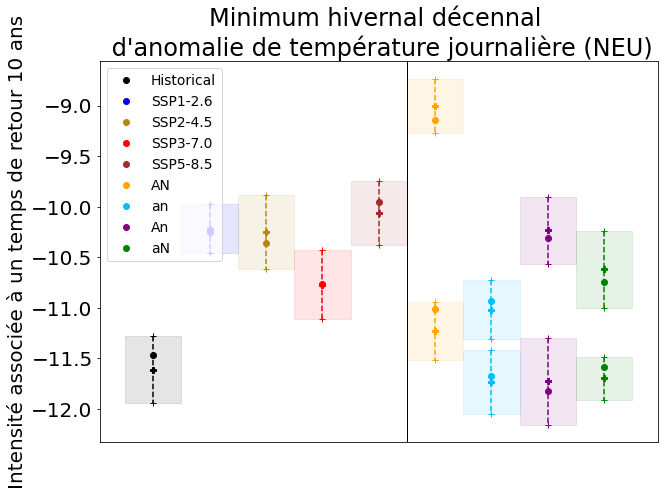

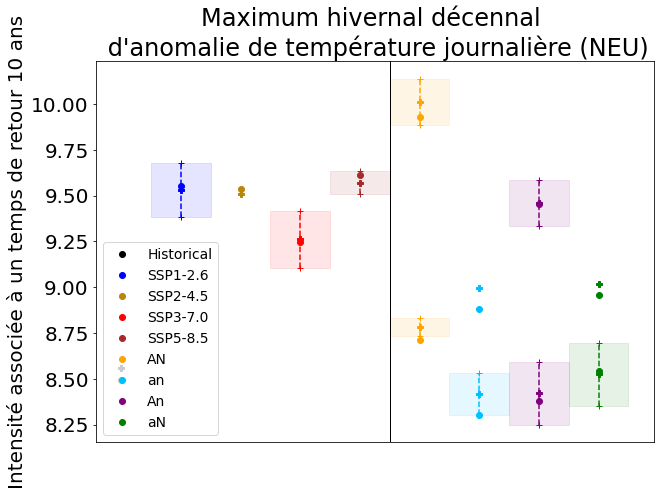

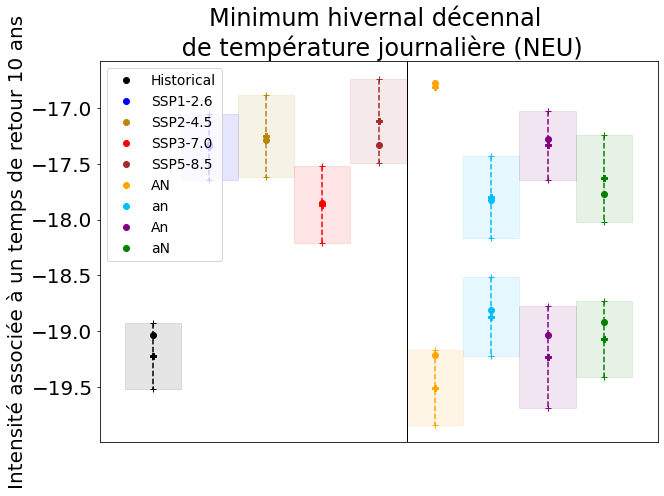

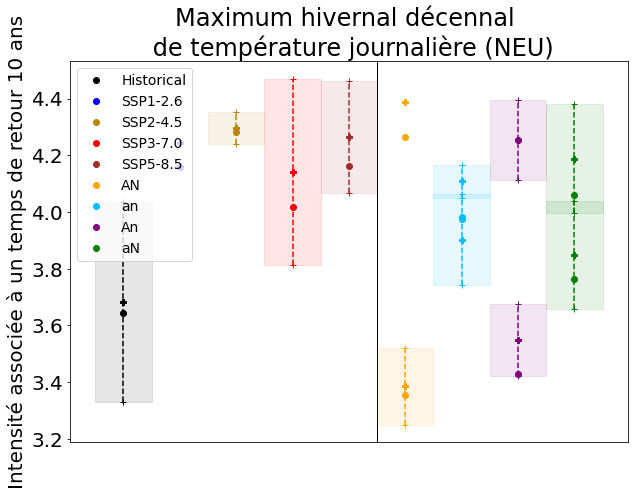

In [22]:
for extr, extremum in enumerate(extrema):

    fig, ax = plt.subplots(figsize=(10, 7))
    #ax.grid(True)

    ax.set_ylabel("Intensité associée à un temps de retour "+str(returnPeriod)+' ans')

    plot_disjoint(changes_save_list[extr].loc[experiment[0]].ntns,
                  changes_save_list[extr].loc[experiment[0]].ntns_inf,
                  changes_save_list[extr].loc[experiment[0]].ntns_sup,
                  changes_save_list[extr].loc[experiment[0]].ntns_app,
                  label = 'Historical')

    for i, e in enumerate(experiment):
        plot_disjoint(changes_save_list[extr].loc[e].new_ntns,
                      changes_save_list[extr].loc[e].new_ntns_inf,
                      changes_save_list[extr].loc[e].new_ntns_sup,
                      changes_save_list[extr].loc[e].new_ntns_app,
                      x=i+1, color = clr_dico[e], label = exp_dico[e])

    plt.axvline(x=len(experiment)+.5, color='k', lw=1)
    for i, s in enumerate(stories):
    #    plot_return_period_change_only(changes_save_list[extr].loc[s], x = i+len(experiment), color = sto_colors[i], label = s)
        plot_disjoint(changes_save_list[extr].loc[s].ntns,
                      changes_save_list[extr].loc[s].ntns_inf,
                      changes_save_list[extr].loc[s].ntns_sup,
                      changes_save_list[extr].loc[s].ntns_app,
                      x=len(experiment)+i+1, color = sto_colors[i], label = s)
        plot_disjoint(changes_save_list[extr].loc[s].new_ntns,
                      changes_save_list[extr].loc[s].new_ntns_inf,
                      changes_save_list[extr].loc[s].new_ntns_sup,
                      changes_save_list[extr].loc[s].new_ntns_app,
                      x=len(experiment)+i+1, color = sto_colors[i])

    ax.legend(fontsize = 'x-small')

    if extremum == 'min_ano':
        plt.title("Minimum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        #plt.xlim(10, 70)
    elif extremum == 'min_raw':
        plt.title("Minimum "+season_txt+" décennal \n de température journalière (NEU)")
        #plt.xlim(10, 70)
    elif extremum == 'max_ano':
        plt.title("Maximum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        #plt.xlim(2, 7)
    elif extremum == 'max_raw':
        plt.title("Maximum "+season_txt+" décennal \n de température journalière (NEU)")
        #plt.xlim(2, 7)

    ax.xaxis.set_visible(False)

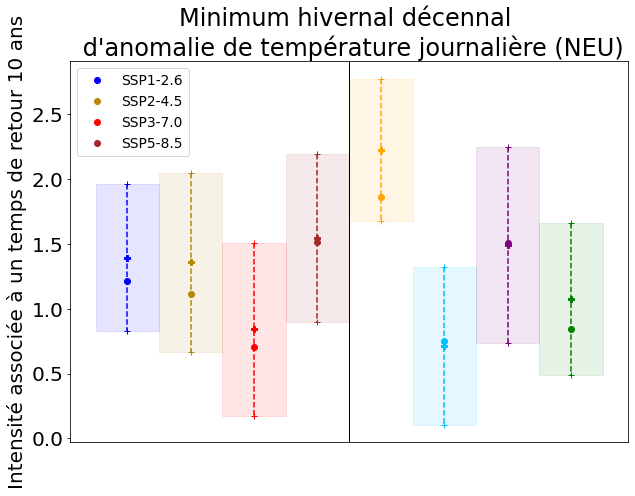

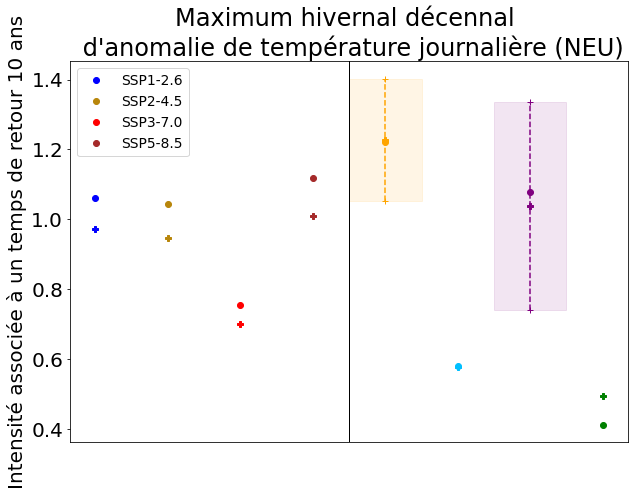

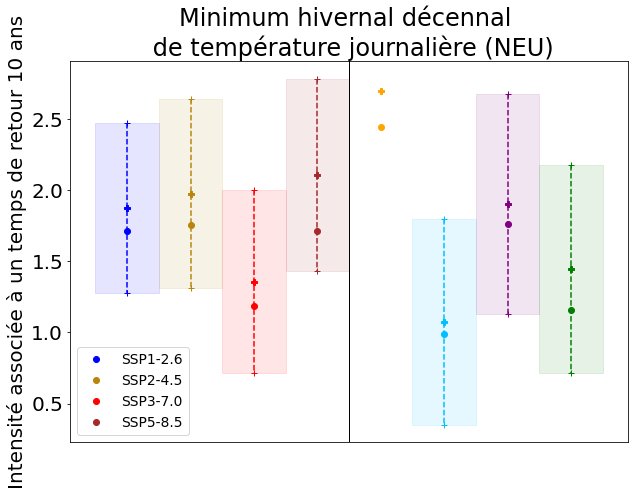

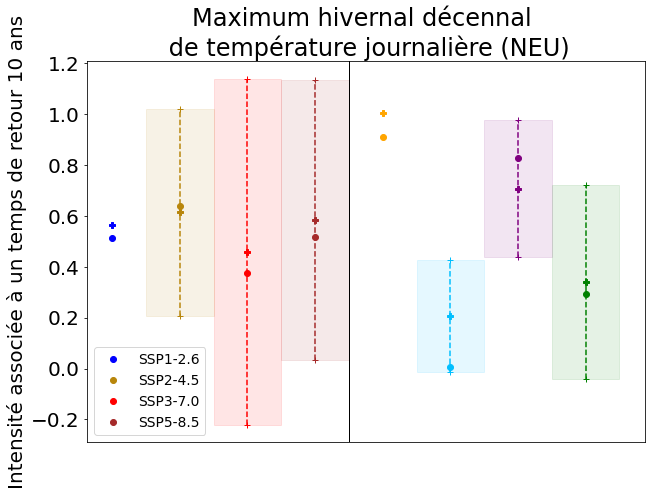

In [23]:
for extr, extremum in enumerate(extrema):

    fig, ax = plt.subplots(figsize=(10, 7))
    #ax.grid(True)

    ax.set_ylabel("Intensité associée à un temps de retour "+str(returnPeriod)+' ans')

    for i, e in enumerate(experiment):
        plot_disjoint(changes_save_list[extr].loc[e].new_ntns - changes_save_list[extr].loc[experiment[0]].ntns,
                      changes_save_list[extr].loc[e].new_ntns_inf - changes_save_list[extr].loc[experiment[0]].ntns_sup,
                      changes_save_list[extr].loc[e].new_ntns_sup - changes_save_list[extr].loc[experiment[0]].ntns_inf,
                      changes_save_list[extr].loc[e].new_ntns_app - changes_save_list[extr].loc[experiment[0]].ntns_app,
                      x=i, color = clr_dico[e], label = exp_dico[e])

    plt.axvline(x=len(experiment)-.5, color='k', lw=1)
    for i, s in enumerate(stories):
    #    plot_return_period_change_only(changes_save_list[extr].loc[s], x = i+len(experiment), color = sto_colors[i], label = s)
        plot_disjoint(changes_save_list[extr].loc[s].new_ntns - changes_save_list[extr].loc[s].ntns,
                      changes_save_list[extr].loc[s].new_ntns_inf - changes_save_list[extr].loc[s].ntns_sup,
                      changes_save_list[extr].loc[s].new_ntns_sup - changes_save_list[extr].loc[s].ntns_inf,
                      changes_save_list[extr].loc[s].new_ntns_app - changes_save_list[extr].loc[s].ntns_app,
                      x=len(experiment)+i, color = sto_colors[i])

    ax.legend(fontsize = 'x-small')

    if extremum == 'min_ano':
        plt.title("Minimum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        #plt.xlim(10, 70)
    elif extremum == 'min_raw':
        plt.title("Minimum "+season_txt+" décennal \n de température journalière (NEU)")
        #plt.xlim(10, 70)
    elif extremum == 'max_ano':
        plt.title("Maximum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        #plt.xlim(2, 7)
    elif extremum == 'max_raw':
        plt.title("Maximum "+season_txt+" décennal \n de température journalière (NEU)")
        #plt.xlim(2, 7)

    ax.xaxis.set_visible(False)

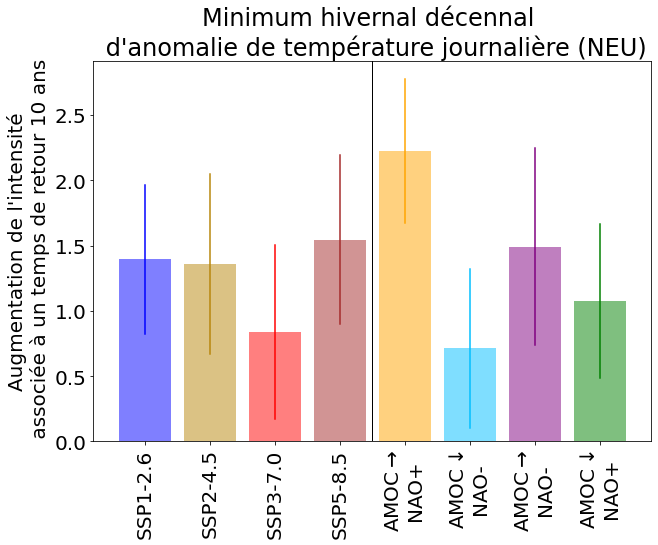

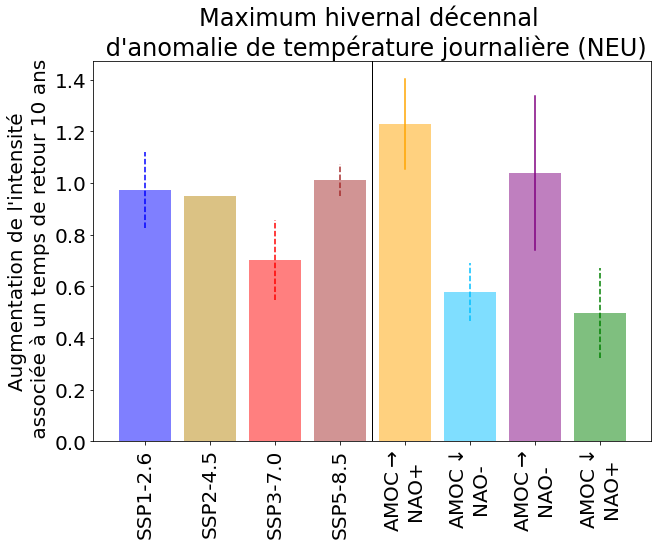

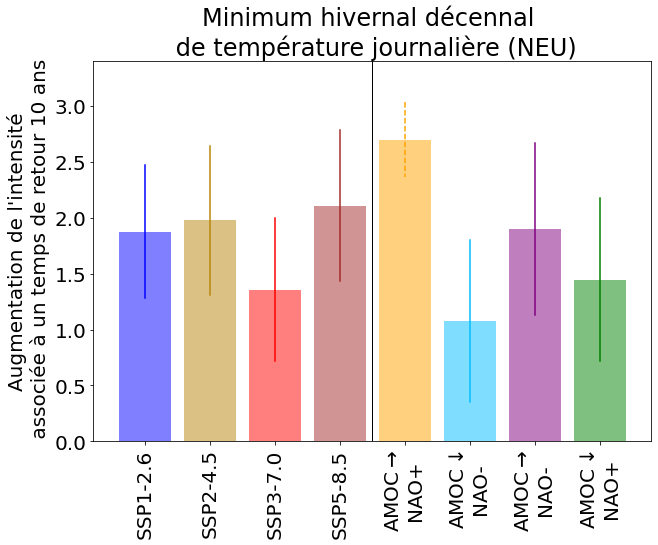

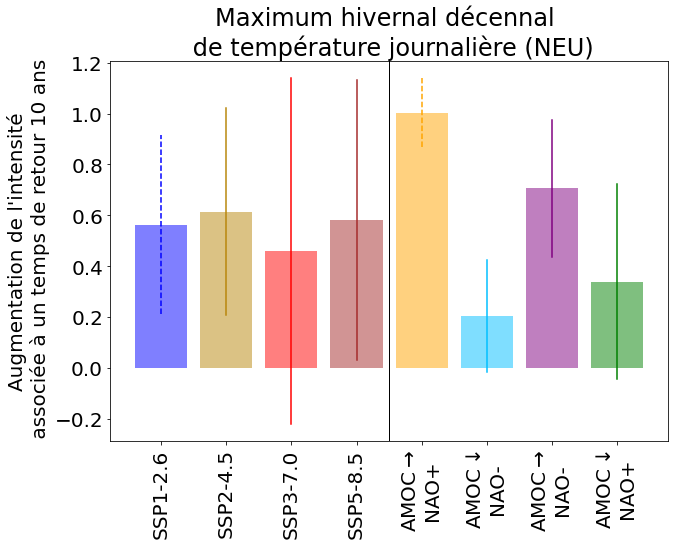

In [61]:
for extr, extremum in enumerate(extrema):

    loc_labels = []

    fig, ax = plt.subplots(figsize=(10, 7))
    #ax.grid(True)

    #ax.set_ylabel("Intensité associée à un temps de retour "+str(returnPeriod)+' ans')
    ax.set_ylabel("Augmentation de l'intensité"+'\n'+" associée à un temps de retour "+str(returnPeriod)+' ans')

    for i, e in enumerate(experiment):
        ant_inf = changes_save_list[extr].loc[experiment[0]].ntns if np.isnan(changes_save_list[extr].loc[experiment[0]].ntns_inf) else changes_save_list[extr].loc[experiment[0]].ntns_inf
        ant_sup = changes_save_list[extr].loc[experiment[0]].ntns if np.isnan(changes_save_list[extr].loc[experiment[0]].ntns_sup) else changes_save_list[extr].loc[experiment[0]].ntns_sup
        post_inf = changes_save_list[extr].loc[e].new_ntns if np.isnan(changes_save_list[extr].loc[e].new_ntns_inf) else changes_save_list[extr].loc[e].new_ntns_inf
        post_sup = changes_save_list[extr].loc[e].new_ntns if np.isnan(changes_save_list[extr].loc[e].new_ntns_sup) else changes_save_list[extr].loc[e].new_ntns_sup

        ls = '--' if np.isnan(changes_save_list[extr].loc[experiment[0]].ntns_inf) or np.isnan(changes_save_list[extr].loc[e].new_ntns_inf) else '-'

        plt.bar(i, changes_save_list[extr].loc[e].new_ntns - changes_save_list[extr].loc[experiment[0]].ntns,
                align = 'center', color = clr_dico[e], label = exp_dico[e], alpha = .5)
        #plt.plot([i, i], [changes_save_list[extr].loc[e].new_ntns_inf - changes_save_list[extr].loc[experiment[0]].ntns_sup,
        #                  changes_save_list[extr].loc[e].new_ntns_sup - changes_save_list[extr].loc[experiment[0]].ntns_inf],
        #         color = clr_dico[e])
        plt.plot([i, i], [post_inf - ant_sup, post_sup - ant_inf], color = clr_dico[e], ls = ls)
        loc_labels.append(exp_dico[e])
    for i, s in enumerate(stories):
        ant_inf = changes_save_list[extr].loc[s].ntns if np.isnan(changes_save_list[extr].loc[s].ntns_inf) else changes_save_list[extr].loc[s].ntns_inf
        ant_sup = changes_save_list[extr].loc[s].ntns if np.isnan(changes_save_list[extr].loc[s].ntns_sup) else changes_save_list[extr].loc[s].ntns_sup
        post_inf = changes_save_list[extr].loc[s].new_ntns if np.isnan(changes_save_list[extr].loc[s].new_ntns_inf) else changes_save_list[extr].loc[s].new_ntns_inf
        post_sup = changes_save_list[extr].loc[s].new_ntns if np.isnan(changes_save_list[extr].loc[s].new_ntns_sup) else changes_save_list[extr].loc[s].new_ntns_sup

        ls = '--' if np.isnan(changes_save_list[extr].loc[s].ntns_inf) or np.isnan(changes_save_list[extr].loc[s].new_ntns_inf) else '-'

        plt.bar(4+i, changes_save_list[extr].loc[s].new_ntns - changes_save_list[extr].loc[s].ntns,
                align = 'center', alpha = .5, color = sto_colors[i], label = s)
        #plt.plot([4+i, 4+i], [changes_save_list[extr].loc[s].new_ntns_inf - changes_save_list[extr].loc[s].ntns_sup,
        #                      changes_save_list[extr].loc[s].new_ntns_sup - changes_save_list[extr].loc[s].ntns_inf],
        #         color = sto_colors[i])
        plt.plot([4+i, 4+i], [post_inf - ant_sup, post_sup - ant_inf], color = sto_colors[i], ls = ls)
        loc_labels.append(storyDico[s])

    plt.axvline(x=len(experiment)-.5, color='k', lw=1)
    """
    for i, s in enumerate(stories):
    #    plot_return_period_change_only(changes_save_list[extr].loc[s], x = i+len(experiment), color = sto_colors[i], label = s)
        plot_disjoint(changes_save_list[extr].loc[s].new_ntns - changes_save_list[extr].loc[s].ntns,
                      changes_save_list[extr].loc[s].new_ntns_inf - changes_save_list[extr].loc[s].ntns_sup,
                      changes_save_list[extr].loc[s].new_ntns_sup - changes_save_list[extr].loc[s].ntns_inf,
                      changes_save_list[extr].loc[s].new_ntns_app - changes_save_list[extr].loc[s].ntns_app,
                      x=len(experiment)+i, color = sto_colors[i])
    """

    #ax.legend(fontsize = 'x-small')
    ax.set_xticks(np.arange(len(loc_labels)))
    ax.set_xticklabels(loc_labels,rotation=90) # 45

    if extremum == 'min_ano':
        plt.title("Minimum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        #plt.xlim(10, 70)
    elif extremum == 'min_raw':
        plt.title("Minimum "+season_txt+" décennal \n de température journalière (NEU)")
        plt.ylim(0,3.4)
        #plt.xlim(10, 70)
    elif extremum == 'max_ano':
        plt.title("Maximum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        #plt.xlim(2, 7)
    elif extremum == 'max_raw':
        plt.title("Maximum "+season_txt+" décennal \n de température journalière (NEU)")
        #plt.xlim(2, 7)

    #ax.xaxis.set_visible(False)

In [25]:
def plot_results(data, ax = None, color='k', alpha=.1, label=None):
    import matplotlib.pyplot

    width = data.rtrn_sup - data.rtrn_inf
    height = data.ntns_sup - data.ntns_inf

    ax = ax or plt.gca()

    ax.add_patch(mpatches.Rectangle((data.rtrn_inf, data.ntns_inf),
                                    width, height,
                                    color=color, alpha=alpha))
    matplotlib.pyplot.plot([data.rtrn, data.rtrn], [data.ntns_inf, data.ntns_sup], '+--', color=color)
    matplotlib.pyplot.plot([data.rtrn_inf, data.rtrn_sup], [data.ntns, data.ntns], '+--', color=color)
    matplotlib.pyplot.plot(data.rtrn_app, data.ntns_app, 'o', color=color, label=label)

In [26]:
def plot_return_period_change_only(data, x=0., ax = None, color='k', alpha=.1, label=None):
    import matplotlib.pyplot

    x=-x
    width = data.rtrn_sup - data.rtrn_inf

    ax = ax or plt.gca()

    ax.add_patch(mpatches.Rectangle((data.rtrn_inf, x-.5),
                                    width, 1.,
                                    color=color, alpha=alpha))
    matplotlib.pyplot.plot(data.rtrn, x, 'P', color=color)
    matplotlib.pyplot.plot([data.rtrn_inf, data.rtrn_sup], [x, x], '+--', color=color)
    matplotlib.pyplot.plot(data.rtrn_app, x, 'o', color=color, label=label)

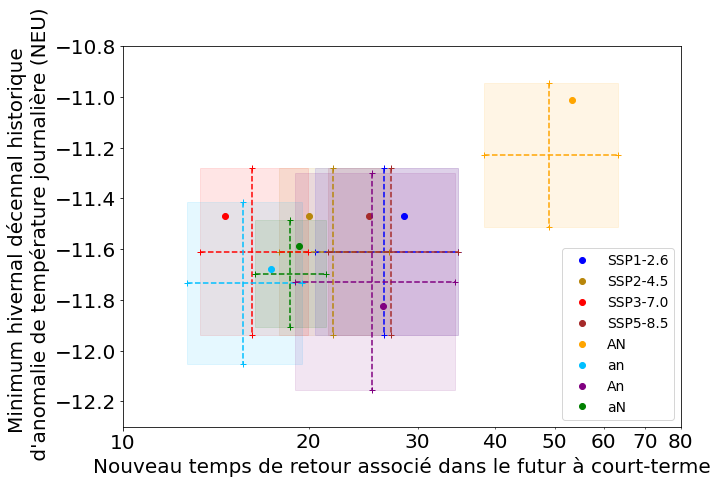

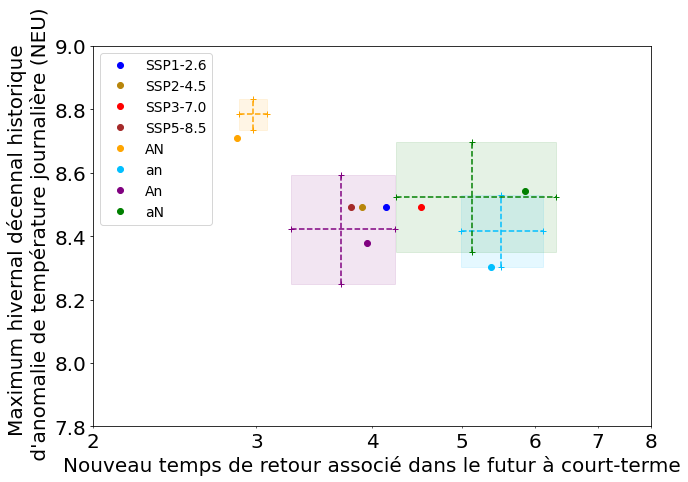

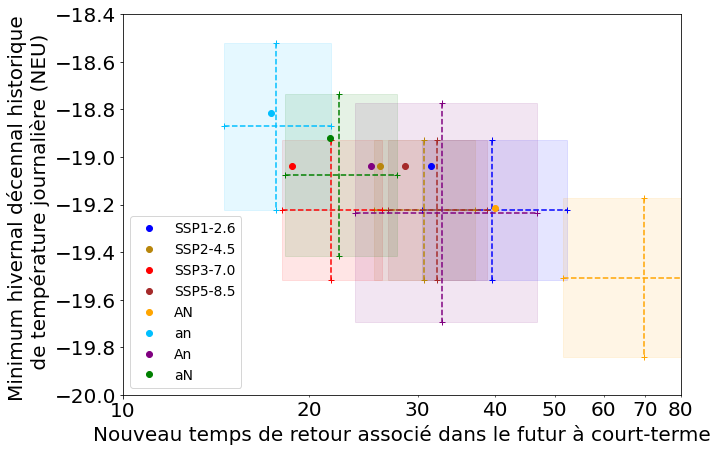

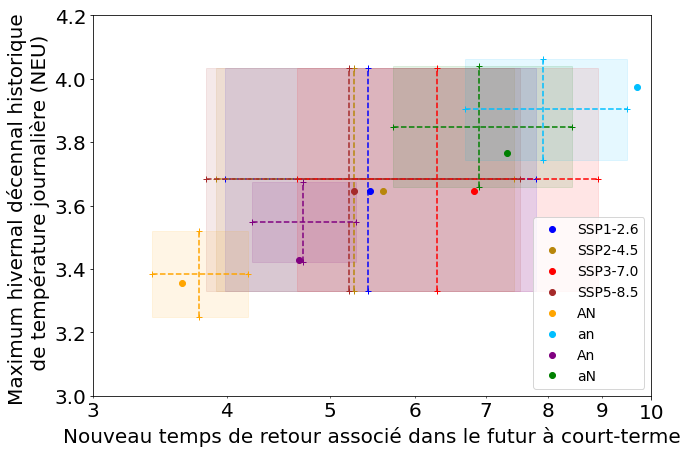

In [27]:
for extr, extremum in enumerate(extrema):

    fig, ax = plt.subplots(figsize=(10, 7))
    #ax.grid(True)

    ax.set_xlabel("Nouveau temps de retour associé dans le futur à court-terme")
    #ax.set_ylabel("Intensité historique d'un évènement décennal")

    for i, e in enumerate(experiment):
        plot_results(changes_save_list[extr].loc[e], ax = ax, color = clr_dico[e], label = exp_dico[e])

    for i, s in enumerate(stories):
        plot_results(changes_save_list[extr].loc[s], ax = ax, color = sto_colors[i], label = s)

    ax.legend(fontsize = 'x-small')

    if extremum == 'min_ano':
        ax.set_ylabel("Minimum "+season_txt+" décennal historique \n d'anomalie de température journalière (NEU)")
        plt.xlim(10, 80)
        plt.ylim(-12.3, -10.8)
    elif extremum == 'min_raw':
        ax.set_ylabel("Minimum "+season_txt+" décennal historique \n de température journalière (NEU)")
        plt.xlim(10, 80)
        plt.ylim(-20, -18.4)
    elif extremum == 'max_ano':
        ax.set_ylabel("Maximum "+season_txt+" décennal historique \n d'anomalie de température journalière (NEU)")
        plt.xlim(2, 8)
        plt.ylim(7.8, 9)
    elif extremum == 'max_raw':
        ax.set_ylabel("Maximum "+season_txt+" décennal historique \n de température journalière (NEU)")
        plt.xlim(3, 10)
        plt.ylim(3, 4.2)

    plt.xscale('log')

    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))

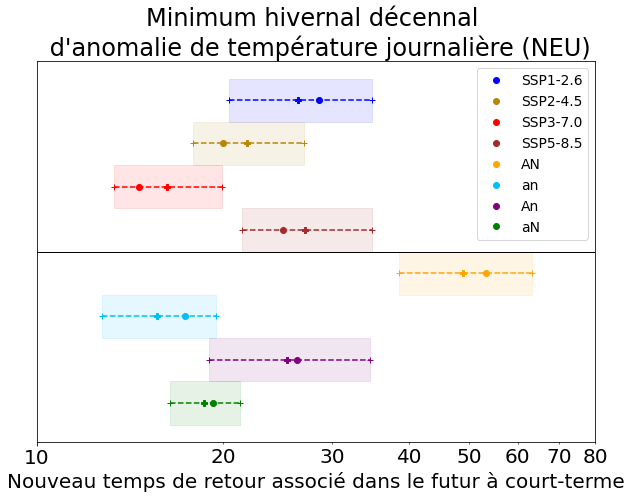

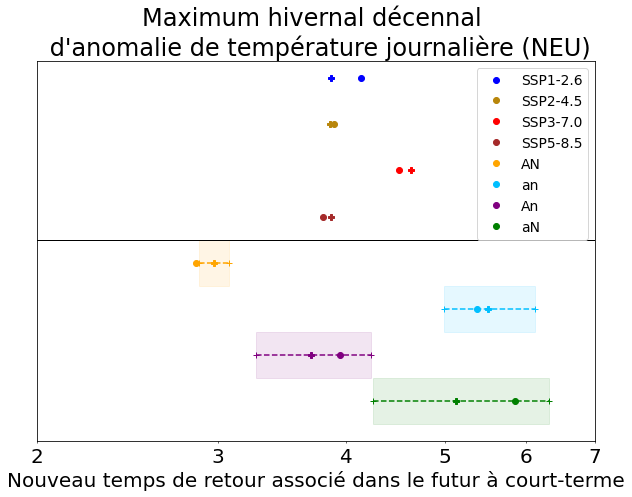

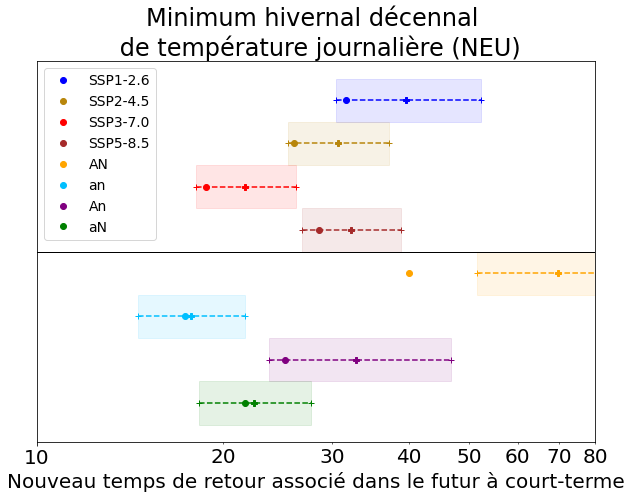

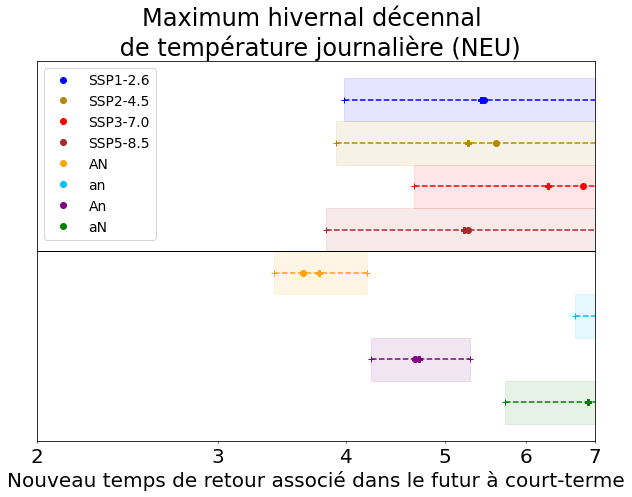

In [28]:
for extr, extremum in enumerate(extrema):

    fig, ax = plt.subplots(figsize=(10, 7))
    #ax.grid(True)

    ax.set_xlabel("Nouveau temps de retour associé dans le futur à court-terme")

    for i, e in enumerate(experiment):
        plot_return_period_change_only(changes_save_list[extr].loc[e], x=i, color = clr_dico[e], label = exp_dico[e])

    plt.axhline(y=-len(experiment)+.5, color='k', lw=1)
    for i, s in enumerate(stories):
        plot_return_period_change_only(changes_save_list[extr].loc[s], x = i+len(experiment), color = sto_colors[i], label = s)

    ax.legend(fontsize = 'x-small')

    if extremum == 'min_ano':
        plt.title("Minimum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        plt.xlim(10, 80)
    elif extremum == 'min_raw':
        plt.title("Minimum "+season_txt+" décennal \n de température journalière (NEU)")
        plt.xlim(10, 80)
    elif extremum == 'max_ano':
        plt.title("Maximum "+season_txt+" décennal \n d'anomalie de température journalière (NEU)")
        plt.xlim(2, 7)
    elif extremum == 'max_raw':
        plt.title("Maximum "+season_txt+" décennal \n de température journalière (NEU)")
        plt.xlim(2, 7)

    plt.xscale('log')

    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_visible(False)

Experiment: hist-ssp126
  Annual maximum
    Extreme warm event associated with a return period of 10 years: 8.58 [8.44 ; 8.71]
    New return period : 3.53 years [3.15 ; 3.98]
  Annual minimum
    Extreme cold event associated with a return period of 10 years: 11.78 [11.44 ; 12.11]
    New return period : 27.12 years [21.06 ; 35.37]
Experiment: hist-ssp245
  Annual maximum
    Extreme warm event associated with a return period of 10 years: 8.58 [8.44 ; 8.71]
    New return period : 3.35 years [2.99 ; 3.78]
  Annual minimum
    Extreme cold event associated with a return period of 10 years: 11.78 [11.44 ; 12.11]
    New return period : 22.83 years [18.59 ; 28.17]
Experiment: hist-ssp370
  Annual maximum
    Extreme warm event associated with a return period of 10 years: 8.58 [8.44 ; 8.71]
    New return period : 4.28 years [3.77 ; 4.89]
  Annual minimum
    Extreme cold event associated with a return period of 10 years: 11.78 [11.44 ; 12.11]
    New return period : 16.24 years [13.28 ;

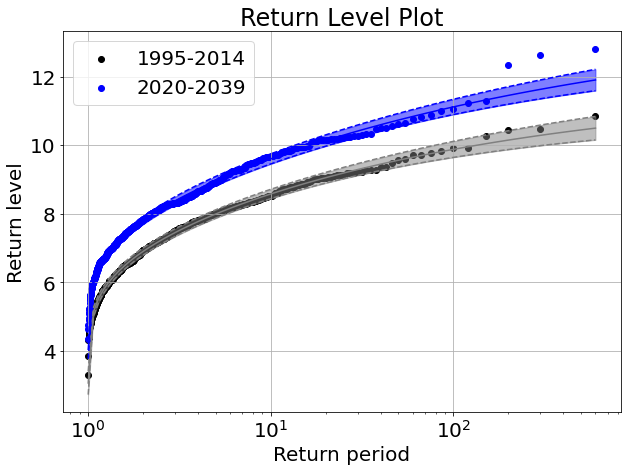

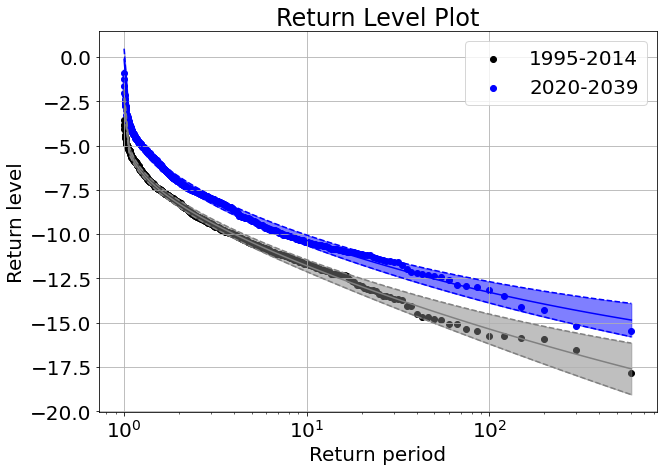

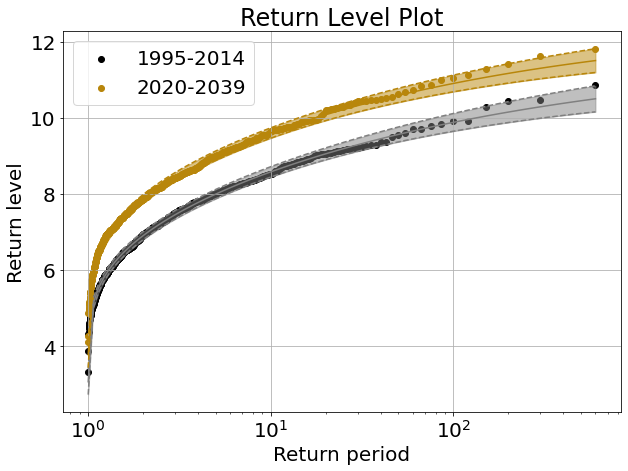

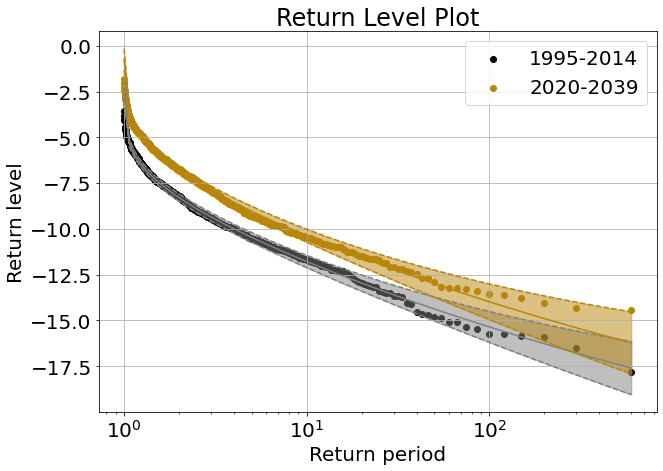

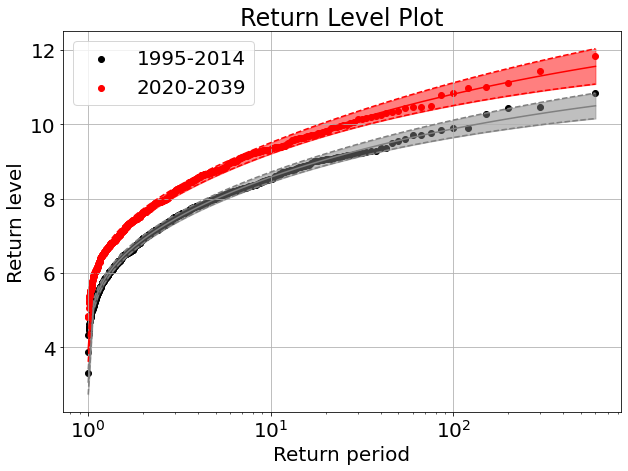

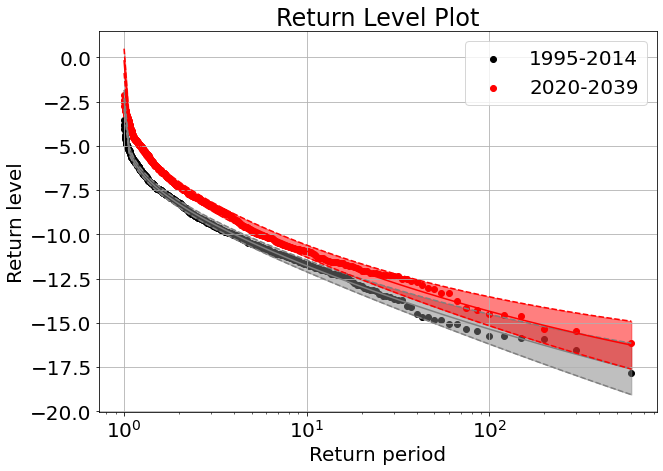

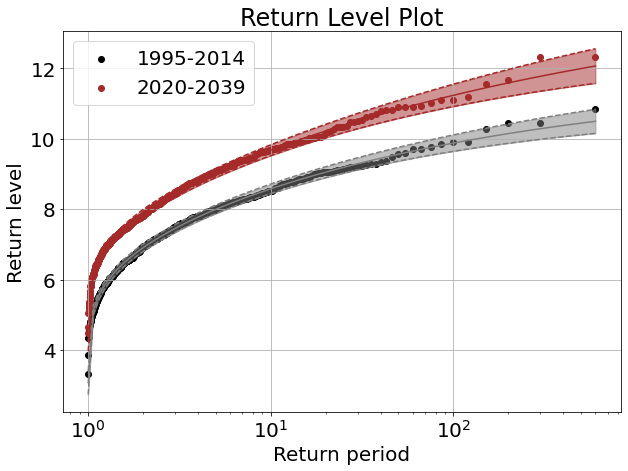

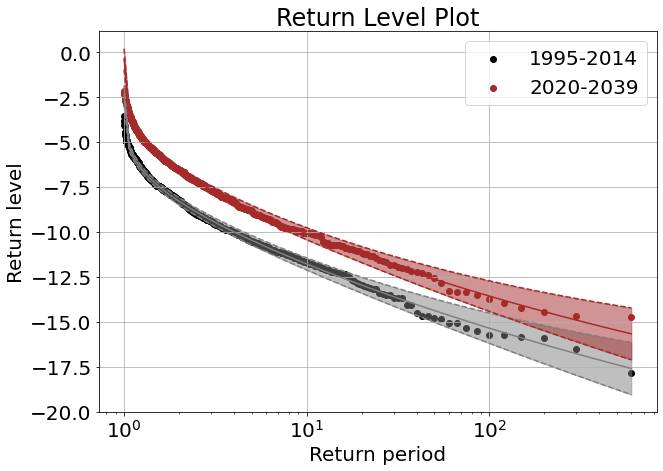

In [29]:
for i, e in enumerate(experiment):

    print('Experiment:', e)
    days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))
    print('  Annual maximum')
    days_ant_max = days_ant.groupby("time.year").max().values.flatten()
    days_post_max = days_post.groupby("time.year").max().values.flatten()

    gev = GEV(days_ant_max)
    rpci = gev.rpci(returnPeriod)

    gev_new = GEV_change(gev, days_post_max)
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))
    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new.plot_return_values_combined(colors = [['k', 'gray'], [clr_dico[e], clr_dico[e]]], # g g
                                        labels = [str(antStart)+'-'+str(antEnd), str(postStart)+'-'+str(postEnd)])

    print('  Annual minimum')
    days_ant_min = days_ant.groupby("time.year").min().values.flatten()
    days_post_min = days_post.groupby("time.year").min().values.flatten()

    gev = GEV(days_ant_min, max_or_min = 'min')
    rpci = gev.rpci(returnPeriod)

    gev_new = GEV_change(gev, days_post_min)
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    Extreme cold event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(-rpci[1]), '[{0:.2f} ;'.format(-rpci[0]), '{0:.2f}]'.format(-rpci[2]))
    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new.plot_return_values_combined(colors = [['k', 'gray'], [clr_dico[e], clr_dico[e]]], # g g
                                        labels = [str(antStart)+'-'+str(antEnd), str(postStart)+'-'+str(postEnd)])
    
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))

Historical
    Extreme warm event associated with a return period of 10 years: 8.58 [8.44 ; 8.71]
Experiment: hist-ssp126
    New return period : 3.53 years [3.15 ; 3.98]
Experiment: hist-ssp245
    New return period : 3.35 years [2.99 ; 3.78]
Experiment: hist-ssp370
    New return period : 4.28 years [3.77 ; 4.89]
Experiment: hist-ssp585
    New return period : 3.32 years [2.97 ; 3.73]


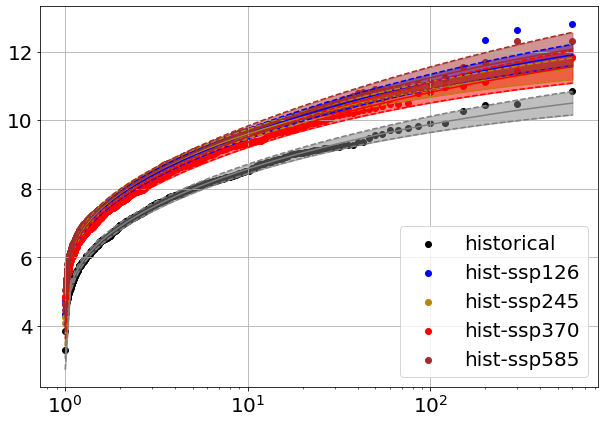

In [30]:
colors = ['blue', 'darkgoldenrod', 'red', 'brown']

fig, ax = plt.subplots(figsize=(10, 7))
ax.grid(True)

print('Historical')
days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
gev = GEV(days_ant.groupby("time.year").max().values.flatten())
rpci = gev.rpci(returnPeriod)

print('    Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))

gev._plot_rtrn(ax, colors = ['k', 'grey'], label = 'historical')

for i, e in enumerate(experiment):
    print('Experiment:', e)
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

    gev_new = GEV_change(gev, days_post.groupby("time.year").max().values.flatten())
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new._plot_rtrn(ax, colors = [clr_dico[e], clr_dico[e]], label = e, new=True)

Historical
    Extreme warm event associated with a return period of 10 years: 8.58 [8.44 ; 8.71]
Experiment: hist-ssp126
    New return period : 3.53 years [3.15 ; 3.98]
Experiment: hist-ssp245
    New return period : 3.35 years [2.99 ; 3.78]
Experiment: hist-ssp370
    New return period : 4.28 years [3.77 ; 4.89]
Experiment: hist-ssp585
    New return period : 3.32 years [2.97 ; 3.73]


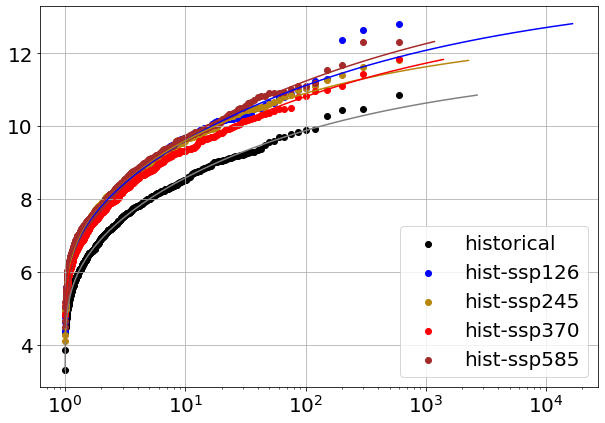

In [31]:
colors = ['blue', 'darkgoldenrod', 'red', 'brown']

fig, ax = plt.subplots(figsize=(10, 7))
ax.grid(True)

print('Historical')
days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
gev = GEV(days_ant.groupby("time.year").max().values.flatten())
rpci = gev.rpci(returnPeriod)

print('    Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))

gev._plot_ntns(ax, colors = ['k', 'grey'], label = 'historical')

for i, e in enumerate(experiment):
    print('Experiment:', e)
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

    gev_new = GEV_change(gev, days_post.groupby("time.year").max().values.flatten())
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new._plot_ntns(ax, colors = [clr_dico[e], clr_dico[e]], label = e, new=True)

Historical
    Extreme warm event associated with a return period of 10 years: -11.78 [-11.44 ; -12.11]
Experiment: hist-ssp126
    New return period : 27.12 years [21.06 ; 35.37]
Experiment: hist-ssp245
    New return period : 22.83 years [18.59 ; 28.17]
Experiment: hist-ssp370
    New return period : 16.24 years [13.28 ; 20.02]
Experiment: hist-ssp585
    New return period : 28.00 years [22.52 ; 35.04]


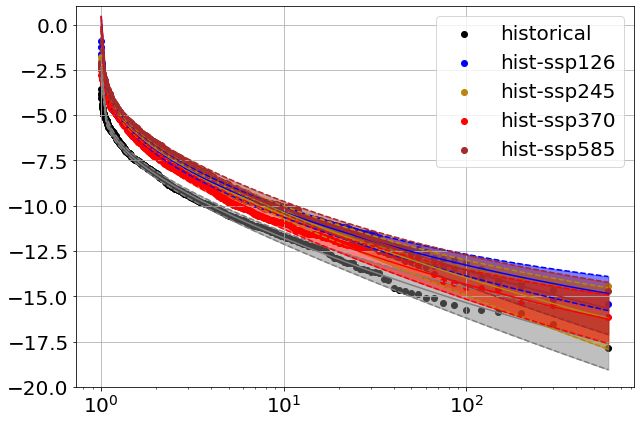

In [32]:
colors = ['blue', 'darkgoldenrod', 'red', 'brown']

fig, ax = plt.subplots(figsize=(10, 7))
ax.grid(True)

print('Historical')
days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
gev = GEV(days_ant.groupby("time.year").min().values.flatten(), max_or_min = 'min')
rpci = gev.rpci(returnPeriod)

print('    Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))

gev._plot_rtrn(ax, colors = ['k', 'grey'], label = 'historical')
plt.ylim(-20, 1)

for i, e in enumerate(experiment):
    print('Experiment:', e)
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

    gev_new = GEV_change(gev, days_post.groupby("time.year").min().values.flatten())
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new._plot_rtrn(ax, colors = [clr_dico[e], clr_dico[e]], label = e, new=True)

Historical
    Extreme warm event associated with a return period of 10 years: 8.58 [8.44 ; 8.71]
Experiment: hist-ssp126
    New return period : 3.53 years [3.15 ; 3.98]
Experiment: hist-ssp245
    New return period : 3.35 years [2.99 ; 3.78]
Experiment: hist-ssp370
    New return period : 4.28 years [3.77 ; 4.89]
Experiment: hist-ssp585
    New return period : 3.32 years [2.97 ; 3.73]
Historical
    Extreme warm event associated with a return period of 10 years: -11.78 [-11.44 ; -12.11]
Experiment: hist-ssp126
    New return period : 27.12 years [21.06 ; 35.37]
Experiment: hist-ssp245
    New return period : 22.83 years [18.59 ; 28.17]
Experiment: hist-ssp370
    New return period : 16.24 years [13.28 ; 20.02]
Experiment: hist-ssp585
    New return period : 28.00 years [22.52 ; 35.04]


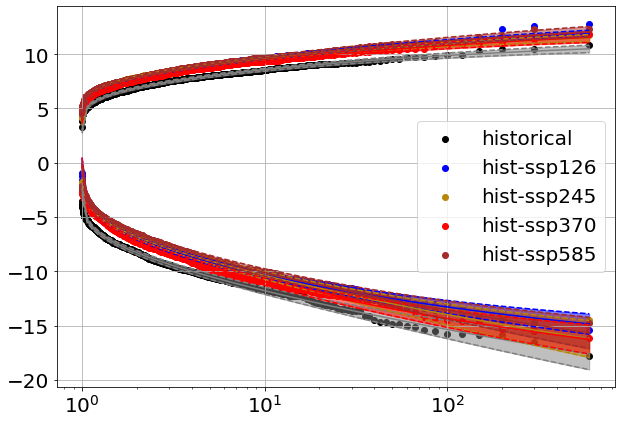

In [33]:
colors = ['blue', 'darkgoldenrod', 'red', 'brown']

fig, ax = plt.subplots(figsize=(10, 7))
ax.grid(True)

print('Historical')
days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
gev = GEV(days_ant.groupby("time.year").max().values.flatten())
rpci = gev.rpci(returnPeriod)

print('    Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))

gev._plot_rtrn(ax, colors = ['k', 'grey'], label = 'historical')

for i, e in enumerate(experiment):
    print('Experiment:', e)
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

    gev_new = GEV_change(gev, days_post.groupby("time.year").max().values.flatten())
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new._plot_rtrn(ax, colors = [clr_dico[e], clr_dico[e]], label = e, new=True)

print('Historical')
days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
gev = GEV(days_ant.groupby("time.year").min().values.flatten(), max_or_min = 'min')
rpci = gev.rpci(returnPeriod)

print('    Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))

gev._plot_rtrn(ax, colors = ['k', 'grey'])

for i, e in enumerate(experiment):
    print('Experiment:', e)
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

    gev_new = GEV_change(gev, days_post.groupby("time.year").min().values.flatten())
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new._plot_rtrn(ax, colors = [clr_dico[e], clr_dico[e]], new=True)

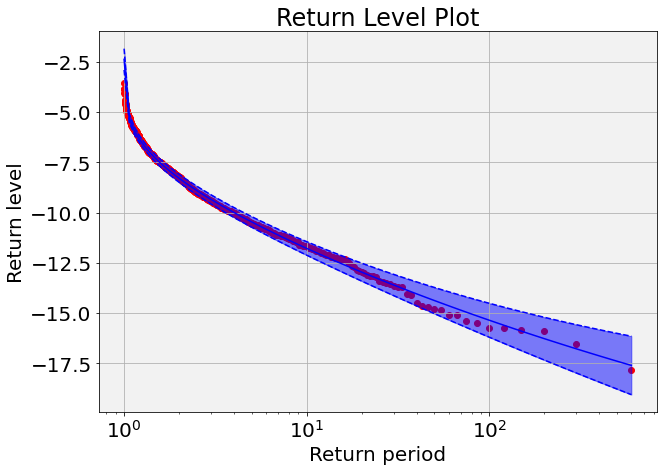

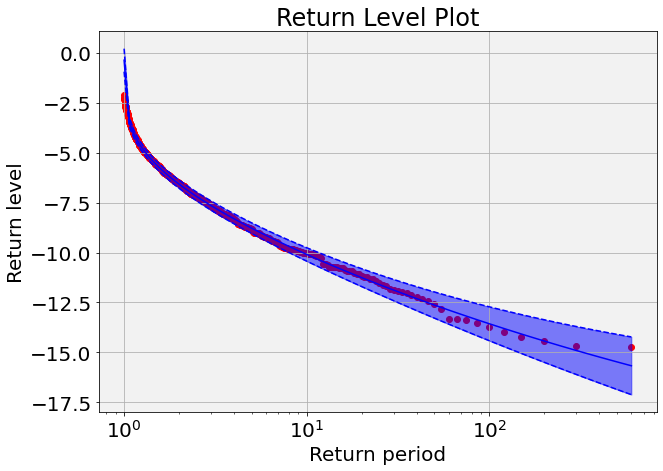

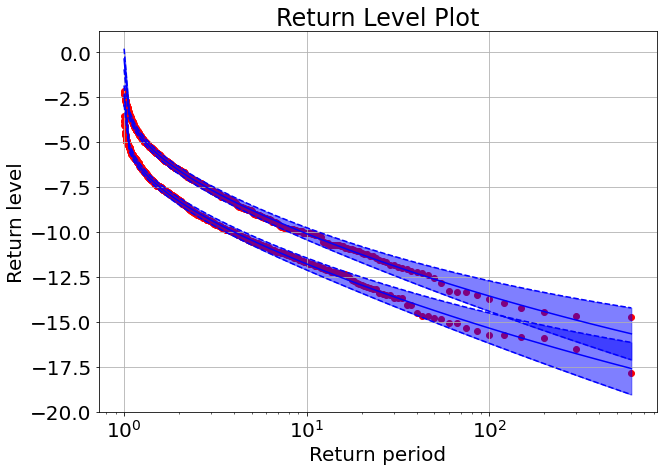

In [34]:
gev_new.plot_return_values()
gev_new.plot_return_values(new = True)
gev_new.plot_return_values_combined()

In [35]:
###
print(A)
###

NameError: name 'A' is not defined

In [ ]:
print(gev.intens)
plt.plot(gev.T, gev.ci_inf)
plt.plot(gev.T, gev.intens)
plt.plot(gev.T, gev.ci_sup)
plt.xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.grid(True)

e = 'hist-ssp126'
#e = 'hist-ssp245'
#e = 'hist-ssp370'
#e = 'hist-ssp585'
plt.title(e)

days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

days_ant_max = days_ant.groupby("time.year").max().values.flatten()
days_post_max = days_post.groupby("time.year").max().values.flatten()

days_ant_max = days_ant.groupby("time.year").min().values.flatten()
days_post_max = days_post.groupby("time.year").min().values.flatten()

#gev = GEV(days_ant_max)
gev = GEV(days_ant_max, max_or_min = 'min')
gev._plot_rtrn(ax, colors = ['k', 'grey'], label = 'historical')

gev_new = GEV_change(gev, days_post_max)

#intensities = np.linspace(days_ant_max.min(), days_ant_max.max())
intensities = np.sort(days_ant_max)

df = pd.DataFrame({'inf': [], 'rtrn': [], 'sup': []})

for INTENS in intensities:
    A, B, C = gev_new.inv_rpci(float(INTENS) * gev_new.factor, new = True)
    df.loc[float(INTENS)] = {'int': A, 'rtrn': B, 'sup': C}

#print(df)

ax.semilogx(df.inf, df.index, '+b')
ax.semilogx(df.rtrn, df.index, 'or')
ax.semilogx(df.sup, df.index, '+b')

In [ ]:
for e in experiment:
    print('Experiment:', e)
    print('  Annual maximum')
    days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
    days_ant_max = days_ant.groupby("time.year").max().values.flatten()
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))
    days_post_max = days_post.groupby("time.year").max().values.flatten()

    gev = GEV(days_ant_max)
    gev.new_data(days_post_max)

    rpci = gev.rpci(returnPeriod)
    rpci_change = gev.rpci_change(returnPeriod)
    print('    Extreme event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))
    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    print('  Annual minimum')
    days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
    days_ant_max = - days_ant.groupby("time.year").min().values.flatten()
    days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))
    days_post_max = - days_post.groupby("time.year").min().values.flatten()

    gev = GEV(days_ant_max)
    gev.new_data(days_post_max)

    rpci = gev.rpci(returnPeriod)
    rpci_change = gev.rpci_change(returnPeriod)
    print('    Extreme event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(-rpci[1]), '[{0:.2f} ;'.format(-rpci[0]), '{0:.2f}]'.format(-rpci[2]))
    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

In [ ]:
###

In [ ]:
gev = GEV(days_anomalies.sel(experiment = 'hist-ssp126', time = slice(str(antStart), str(antEnd))).groupby("time.year").max().values.flatten(),
          print_comments = True)

In [ ]:
gev.new_data(days_anomalies.sel(experiment = 'hist-ssp126', time = slice(str(postStart), str(postEnd))).groupby("time.year").max().values.flatten())

In [ ]:
print(gev.rpci(returnPeriod))
print(gev.inv_rpci(gev.rpci(returnPeriod)[1]))
print(gev.rpci_change(returnPeriod))

In [ ]:
gev.gev.plot_density(); gev.gev.plot_return_values();
gev.gev_new.plot_density(); gev.gev_new.plot_return_values();

In [ ]:
# Events of extreme hot temperatures
#rpRef = 273.15
TMP_rpAntData = days_anomalies.sel(experiment = 'hist-ssp126', time = slice(str(antStart), str(antEnd)))
rpAntData = TMP_rpAntData.groupby("time.year").max().values.flatten()
TMP_rpPostData = days_anomalies.sel(experiment = 'hist-ssp126', time = slice(str(postStart), str(postEnd)))
rpPostData = TMP_rpPostData.groupby("time.year").max().values.flatten()
output = compute_return_periode_change(returnPeriod, rpAntData, rpPostData, years_number = 1, extended_output = True)
tmp1.plot_return_values()
tmp2.plot_return_values()
print('Original return period:', returnPeriod)
print('Associated extreme: {0:.2f}'.format(tmp1.ppf(1-1/b)), '[{0:.2f} ;'.format(tmp1.ppf(1-1/a)), '{0:.2f}]'.format(tmp1.ppf(1-1/c)))
print('New return period: {0:.2f}'.format(b), '[{0:.2f} ;'.format(a), '{0:.2f}]'.format(c))
print('Associated extreme: {0:.2f}'.format(tmp2.ppf(1-1/b)), '[{0:.2f} ;'.format(tmp2.ppf(1-1/a)), '{0:.2f}]'.format(tmp2.ppf(1-1/c)))

In [ ]:
class GEV:

    def __init__(self, data,
                 print_comments=False,
                 years_number=1, theta=1., conf=.95,
                 skextremes_fit_method=, ci_method='delta'):

        self.data = data
        self.print_comments = print_comments
        self.years_number = years_number; self.theta = theta; self.conf = conf;
        self.fit_method = fit_method; self.ci_method = ci_method;

        self._fit()
        self.varcovar = varcovar(self.data, self.location, self.scale, self.shape)
        
    def _fit(self):
        import skextremes

        self.gev = skextremes.models.classic.GEV(data = self.data,
                                                 fit_method = self.fit_method,
                                                 ci = self.conf,
                                                 ci_method = self.ci_method,
                                                 frec = self.years_number)

        self.location = self.gev.loc
        self.scale = self.gev.scale
        self.shape = self.gev.c

    def varcovar(data, location, scale, shape):
        """
        """
        import numpy
        import numdifftools
        
        def loc_fun(param):
            if len(param) == 3:
                _location = param[0]; _scale = param[1]; _shape = param[2]
            if len(param) == 2:
                _location = param[0]; _scale = param[1]; _shape = 0
            if _shape != 0:
                tmp = numpy.array([1. + _shape * (data - _location) / _scale])
                expr = tmp[tmp > 0.]
                out = (len(expr) * numpy.log(_scale) +  (1. + 1. / _shape) * numpy.sum(numpy.log(expr)) + numpy.sum(expr ** (-1. / _shape)))
            else:
                expr = (data - _location) / _scale
                out =  (len(data) * numpy.log(_scale) + numpy.sum(expr) + numpy.sum(numpy.exp(- expr)))
            return out

        hess = numdifftools.Hessian(loc_fun)

        return  numpy.linalg.inv(hess([location, scale, shape]))

    def new_data(self, new_data):
        """
        """
        import skextremes

        self.gev_new = skextremes.models.classic.GEV(data = new_data,
                                                     fit_method = self.fit_method,
                                                     ci = self.conf,
                                                     ci_method = self.ci_method,
                                                     frec = self.years_number)
        self.location_new = self.gev_new.loc
        self.scale_new = self.gev_new.scale
        self.shape_new = self.gev_new.c

        self.varcovar_new = varcovar(new_data, self.location_new, self.scale_new, self.shape_new)

    def rpci(self, return_period):
        """
        rcpi: Return Period Confidenc Interval
        Returns the intensity and confidence interval associated to the return period 'return_period'.
        """
        import numpy
        import numdifftools
        import scipy.stats

        p = 1. / (return_period * self.years_number)
        yp = - numpy.log(1. - p) / self.theta

        if self.shape == 0.:
            intens = self.location - self.scale * numpy.log(yp)
            Jac = numpy.array([1., - numpy.log(yp)])
        else:
            intens = self.location - (self.scale / self.shape) * (1. - yp ** (- self.shape))
            Jac = numpy.array([1.,
                               - (1. - yp ** (- self.shape)) / self.shape,
                               self.scale / self.shape ** 2. * yp ** (- self.shape) * (yp ** self.shape - self.shape * numpy.log(yp) - 1)])

        var = numpy.dot(Jac, numpy.dot(self.varcovar, Jac))
        ci_inf = intens - scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var)
        ci_sup = intens + scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var)

        return ci_inf, intens, ci_sup

    def inv_rpci(self, intens, target='original'):
        """
        inv_rcpi: Inverse Return Period Confidenc Interval
        Returns the return period and conficence interval for the new dataset
        associated with the intensity and confidence interval for the return period 'return_period'
        with the original dataset.
        """
        import numpy
        import numdifftools
        import scipy.stats

        if target == 'original':
            _location = self.location
            _scale = self.scale
            _shape = self.shape
            _varcovar = self.varcovar
        elif target == 'new':
            _location = self.location_new
            _scale = self.scale_new
            _shape = self.shape_new
            _varcovar = self.varcovar_new

        if _shape == 0.:
            print('Not codded yet.')
        else:
            return_period = 1. / (1. - numpy.exp(- self.theta * (1. + _shape / _scale * (intens - _location)) ** (- 1. / _shape))) / self.years_number
            racc1 = _shape / _scale * (intens - _location) + 1.
            racc2 = numpy.exp(- self.theta * racc1 ** (- _shape))
            Jac = numpy.array([
                - self.theta * racc1 ** (- 1. / _shape - 1.) * racc2 / self.years_number / _scale / (1. - racc2) ** 2.,
                - self.theta * (intens - _location) * racc1 ** (- 1. / _shape - 1.) * racc2 / self.years_number / _scale ** 2. / (1. - racc2) ** 2.,
                - self.theta * racc1 ** (- 1. / _shape) * racc2 * (numpy.log(racc1) / _shape ** 2. - (intens - _location) / _shape / _scale / racc1) / self.years_number / (1. - racc2) ** 2.
            ])

        var = numpy.dot(numpy.dot(Jac, _varcovar), Jac)
        ci_inf = return_period - scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var)
        ci_sup = return_period + scipy.stats.norm.ppf((1. + self.conf) / 2.) * numpy.sqrt(var)

        return ci_inf, return_period, ci_sup

    def rpci_change(self, return_period):
        """
        """

        _ci_inf, _intens, _ci_sup = self.rpci(return_period)
        ci_inf, _, _ = self.inv_rpci(_ci_inf, target='new')
        _, new_return_period, _ = self.inv_rpci(_intens, target='new')
        _, _, ci_sup = self.inv_rpci(_ci_sup, target='new')

        if self.print_comments:
            print('GEV PRINT: Original return period:', return_period, 'years')
            print('GEV PRINT: Associated extreme: {0:.2f}'.format(_intens), '[{0:.2f} ;'.format(_ci_inf), '{0:.2f}]'.format(_ci_sup))
            print('GEV PRINT: New return period: {0:.2f}'.format(new_return_period), 'years [{0:.2f} ;'.format(ci_inf), '{0:.2f}]'.format(ci_sup))
            # Associated ...

        return ci_inf, new_return_period, ci_sup

In [ ]:

def varcovar(data, location, scale, shape=0):
    import numpy
    import numdifftools

    def loc_fun(param):
        if len(param) == 3:
            location = param[0]; scale = param[1]; shape = param[2]
        if len(param) == 2:
            location = param[0]; scale = param[1]; shape = 0
        if shape != 0:
            tmp = numpy.array([1. + shape * (data - location) / scale])
            expr = tmp[tmp > 0.]
            out = (len(expr) * numpy.log(scale) +  (1. + 1. / shape) * numpy.sum(numpy.log(expr)) + numpy.sum(expr ** (-1. / shape)))
            #expr = numpy.where(tmp < 0., 0., tmp)
            #out = (len(data) * numpy.log(scale) +  (1. + 1. / shape) * numpy.sum(numpy.log(expr)) + numpy.sum(expr ** (-1. / shape)))
        else:
            expr = (data - location) / scale
            out =  (len(data) * numpy.log(scale) + numpy.sum(expr) + numpy.sum(numpy.exp(- expr)))
        return out

    hess = numdifftools.Hessian(loc_fun)

    return numpy.linalg.inv(hess([location, scale, shape]))

def varcovar2(data, location, scale, shape=0):
    import numpy
    import numdifftools

    def loc_fun(param):
        if len(param) == 3:
            location = param[0]; scale = param[1]; shape = param[2]
        if len(param) == 2:
            location = param[0]; scale = param[1]; shape = 0
        if shape != 0:
            tmp = numpy.array([1. + shape * (data - location) / scale])
            expr = tmp[tmp > 0.]
            out = (len(expr) * numpy.log(scale) +  (1. + 1. / shape) * numpy.sum(numpy.log(expr)) + numpy.sum(expr ** (-1. / shape)))
        else:
            expr = (data - location) / scale
            out =  (len(data) * numpy.log(scale) + numpy.sum(expr) + numpy.sum(numpy.exp(- expr)))
        return out

    hess = numdifftools.Hessian(loc_fun)

    u, s, vh = numpy.linalg.svd(numpy.linalg.inv(hess([location, scale, shape])))

    s = np.diag(s)
    print('s before:', s)
    print(s)
    s[s < 0.] = 0# = numpy.where(s < 0., 0., s)
    print('s after:', s)

    return numpy.dot(u, numpy.dot(s, vh))

def return_period_confidence_interval(return_period, years_number, location, scale, shape, varcov, theta=1., conf=0.95):
    import numpy
    import numdifftools
    from scipy.stats import norm

    #print('location:', '{0:.2f}'.format(location)); print('scale:', '{0:.2f}'.format(scale)); print('shape:', '{0:.2f}'.format(shape)); print('varcov:', varcov)

    p = 1. / (return_period * years_number)
    yp = - numpy.log(1. - p) / theta
    #print('p:', '{0:.2f}'.format(p)); print('yp:', '{0:.2f}'.format(yp))

    if shape == 0.:
        z = location - scale * numpy.log(yp)
        Jac = numpy.array([1., - numpy.log(yp)])
    else:
        z = location - (scale / shape) * (1. - yp ** (- shape))
        Jac = numpy.array([1.,
                           - (1. - yp ** (- shape)) / shape,
                           scale / shape ** 2. * yp ** (- shape) * (yp ** shape - shape * numpy.log(yp) - 1)])
                           # - scale / shape ** 2. * (scale/shape * numpy.log(yp) * yp ** (- shape) - 1. + yp ** (- shape))])
                           # - scale / shape ** 2. * shape * numpy.log(yp) * yp ** (-shape) - 1. + yp ** (-shape)
    #print('z:', '{0:.2f}'.format(z)); print('Jac:', Jac)

    #print(numpy.linalg.svd(varcov))
    #print(varcov)
    #print(Jac)
    #print(numpy.dot(varcov, Jac))
    var = numpy.dot(Jac, numpy.dot(varcov, Jac))
    #print(var)
    ci_inf = z - norm.ppf((1. + conf) / 2.) * numpy.sqrt(var)
    ci_sup = z + norm.ppf((1. + conf) / 2.) * numpy.sqrt(var)
    #print('var:', '{0:.2f}'.format(var)); print('ci_inf:', '{0:.2f}'.format(ci_inf)); print('ci_sup:', '{0:.2f}'.format(ci_sup))

    return ci_inf, z, ci_sup, var

def inverse_return_period_confidence_interval(return_value, years_number, location, scale, shape, varcov, theta=1., conf=0.95):
    import numpy
    import numdifftools
    from scipy.stats import norm

    #print('location:', '{0:.2f}'.format(location)); print('scale:', '{0:.2f}'.format(scale)); print('shape:', '{0:.2f}'.format(shape)); print('varcov:', varcov)
    
    if shape == 0.:
        print('Not codded yet.')
    else:
        t = 1. / (1. - numpy.exp(- theta * (1. + shape / scale * (return_value - location)) ** (- 1. / shape))) / years_number
        racc1 = shape / scale * (return_value - location) + 1.
        racc2 = numpy.exp(- theta * racc1 ** (- shape))
        Jac = numpy.array([
            - theta * racc1 ** (- 1. / shape - 1.) * racc2 / years_number / scale / (1. - racc2) ** 2.,
            - theta * (return_value - location) * racc1 ** (- 1. / shape - 1.) * racc2 / years_number / scale ** 2. / (1. - racc2) ** 2.,
            - theta * racc1 ** (- 1. / shape) * racc2 * (numpy.log(racc1) / shape ** 2. - (return_value - location) / shape / scale / racc1) / years_number / (1. - racc2) ** 2.
        ])

    #print('t:', '{0:.2f}'.format(t)); print('Jac:', Jac)

    var = numpy.dot(numpy.dot(Jac, varcov), Jac)
    ci_inf = t - norm.ppf((1. + conf) / 2.) * numpy.sqrt(var)
    ci_sup = t + norm.ppf((1. + conf) / 2.) * numpy.sqrt(var)
    #print('var:', '{0:.2f}'.format(var)); print('ci_inf:', '{0:.2f}'.format(ci_inf)); print('ci_sup:', '{0:.2f}'.format(ci_sup))

    return ci_inf, t, ci_sup, var

def compute_return_periode_change(period, antData, postData, years_number=1, theta=1., conf=.95, fit_method='mle', extended_output=False):

    GEVant = skextremes.models.classic.GEV(data = antData,
                                           fit_method = fit_method,
                                           ci = conf,
                                           ci_method = 'delta',
                                           frec = years_number)

    print('loc:', '{0:.2f}'.format(GEVant.loc), 'scale:', '{0:.2f}'.format(GEVant.scale), 'shape:', '{0:.2f}'.format(GEVant.c))

    CI_INF1, INTENS1, CI_SUP1, _ = return_period_confidence_interval(period, years_number, GEVant.loc, GEVant.scale, GEVant.c,
                                                                  varcovar(antData, GEVant.loc, GEVant.scale, GEVant.c))

    print(CI_INF1, INTENS1, CI_SUP1)

    GEVpost = skextremes.models.classic.GEV(data = postData,
                                            fit_method = fit_method,
                                            ci = conf,
                                            ci_method = 'delta',
                                            frec = years_number)

    VARCOVAR = varcovar(postData, GEVpost.loc, GEVpost.scale, GEVpost.c)

    CI_INF2, _, _, _ = inverse_return_period_confidence_interval(CI_INF1, years_number,
                                                                 GEVpost.loc, GEVpost.scale, GEVpost.c, VARCOVAR,
                                                                 theta=theta, conf=conf)

    _, INTENS2, _, _ = inverse_return_period_confidence_interval(INTENS1, years_number,
                                                                 GEVpost.loc, GEVpost.scale, GEVpost.c, VARCOVAR,
                                                                 theta=theta, conf=conf)

    _, _, CI_SUP2, _ = inverse_return_period_confidence_interval(CI_SUP1, years_number,
                                                                 GEVpost.loc, GEVpost.scale, GEVpost.c, VARCOVAR,
                                                                 theta=theta, conf=conf)
    if extended_output:
        out = CI_INF2, INTENS2, CI_SUP2, GEVpost, CI_INF1, INTENS1, CI_SUP1, GEVant
    else:
        out = CI_INF2, INTENS2, CI_SUP2

    return out

In [ ]:
changes_save_list = []
for extremum in ('min_ano', 'min_raw'):
                # min_ano max_ano min_raw
    
    chngs = changes_save.copy(deep=True)

    for i, e in enumerate(experiment):

        fig, ax = plt.subplots(figsize=(10, 7))
        ax.grid(True)

        print('Experiment:', e)
        days_ant = season_days.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
        days_post = season_days.sel(experiment = e, time = slice(str(postStart), str(postEnd)))
        ano_days_ant = days_anomalies.sel(experiment = e, time = slice(str(antStart), str(antEnd)))
        ano_days_post = days_anomalies.sel(experiment = e, time = slice(str(postStart), str(postEnd)))

        if extremum == 'min_ano':
            print(' Seasonnal min (anomaly)')
            max_or_min = 'min'
            days_ant_extr = ano_days_ant.groupby("time.year").min().values.flatten()
            days_post_extr = ano_days_post.groupby("time.year").min().values.flatten()
            sorted_days_ant = np.sort(days_ant_extr)[::-1]
            sorted_days_post = np.sort(days_post_extr)[::-1]
        elif extremum == 'min_raw':
            print(' Seasonnal min (raw)')
            max_or_min = 'min'
            days_ant_extr = days_ant.groupby("time.year").min().values.flatten()
            days_post_extr = days_post.groupby("time.year").min().values.flatten()
            sorted_days_ant = np.sort(days_ant_extr)[::-1]
            sorted_days_post = np.sort(days_post_extr)[::-1]
        elif extremum == 'max':
            print(' Seasonnal max (anomaly)')
            max_or_min = 'max_ano'
            days_ant_extr = ano_days_ant.groupby("time.year").max().values.flatten()
            days_post_extr = ano_days_post.groupby("time.year").max().values.flatten()
            sorted_days_ant = np.sort(days_ant_extr)
            sorted_days_post = np.sort(days_post_extr)

        print('   Raw estimations')
        rpci_raw = sorted_days_ant[int(len(days_ant_extr)*(1. - 1. / returnPeriod))]
        inv_rpci_raw = len(days_post_extr) / (len(days_post_extr) - (np.abs(sorted_days_post - rpci_raw)).argmin())

        #print('  Annual maximum')
        #days_ant_max = days_ant.groupby("time.year").max().values.flatten()
        #days_post_max = days_post.groupby("time.year").max().values.flatten()
        #print('  Annual minimum')
        #days_ant_min = days_ant.groupby("time.year").min().values.flatten()
        #days_post_min = days_post.groupby("time.year").min().values.flatten()

        print('     Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci_raw))
        print('     New return period: {0:.2f}'.format(inv_rpci_raw), 'years')

        plt.axhline(y=rpci_raw, color='gray', linestyle=':')
        plt.axvline(x=inv_rpci_raw, color='gray', linestyle=':')

        print('   GEV estimations')
        gev = GEV(days_ant_extr, max_or_min = max_or_min)
        rpci = gev.rpci(returnPeriod)

        gev_new = GEV_change(gev, days_post_extr)
        rpci_change = gev_new.rpci_change(returnPeriod)

        print('     Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))
        print('     New return period: {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

        chngs.loc[e] = {'rtrn_app': inv_rpci_raw, 'rtrn': rpci_change[1], 'rtrn_inf': rpci_change[0], 'rtrn_sup': rpci_change[2],
                        'ntns_app': rpci_raw, 'ntns': rpci[1], 'ntns_inf': rpci[0], 'ntns_sup': rpci[2]}

        #gev_new.plot_return_values_combined(colors = [['k', 'g'], [colors[i], 'g']],
        #                                    labels = [str(antStart)+'-'+str(antEnd), str(postStart)+'-'+str(postEnd)])

        gev._plot_rtrn(ax, colors = ['k', 'gray'], label = 'Historical')
        gev_new._plot_ntns(ax, colors = [clr_dico[e], clr_dico[e]], label = 'SSP1-2.6', new=True)

        plt.axhline(y=rpci[1], color='gray', linestyle='--')
        plt.axvline(x=rpci_change[0], color='gray', linestyle='--')
        plt.axvline(x=rpci_change[1], color='gray', linestyle='--')
        plt.axvline(x=rpci_change[2], color='gray', linestyle='--')

        ax.plot([inv_rpci_raw, returnPeriod], [rpci_raw, rpci_raw], 'o-k')
        ax.plot([rpci_change[0], returnPeriod], [rpci[0], rpci[0]], 'o-k')
        ax.plot([rpci_change[1], returnPeriod], [rpci[1], rpci[1]], 'o-k')
        ax.plot([rpci_change[2], returnPeriod], [rpci[2], rpci[2]], 'o-k')

        if extremum == 'min_ano':
            plt.xlim(8, 80)
            plt.ylim(-17, -9)
            plt.ylim(-12.5, -11)
        elif extremum == 'min_raw':
            plt.xlim(8, 80)
            plt.ylim(-21, -18)
        elif extremum == 'max_ano':
            plt.xlim(2, 20)
            plt.ylim(6, 11)

        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
        ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))

        plt.show()

    for i, s in enumerate(stories):
        print('allez on remplit')

    changes_save_list.append(chngs)

    print()

In [ ]:
for i, s in enumerate(stories):

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.grid(True)

    print('Story:', s)
    days_ant = story_days_anomalies.sel(member = story_dico[s], time = slice(str(antStart), str(antEnd)))
    days_post = story_days_anomalies.sel(member = story_dico[s], time = slice(str(postStart), str(postEnd)))

    #print('  Annual maximum')
    #days_ant_max = days_ant.groupby("time.year").max().values.flatten()
    #days_post_max = days_post.groupby("time.year").max().values.flatten()
    print('  Annual minimum')
    days_ant_min = days_ant.groupby("time.year").min().values.flatten()
    days_post_min = days_post.groupby("time.year").min().values.flatten()

    print('   Raw estimations')
    #rpci_raw = np.sort(days_ant_max)[int(len(days_ant_max)*(1. - 1. / returnPeriod))]
    #inv_rpci_raw = len(days_post_max) / (len(days_post_max) - (np.abs(np.sort(days_post_max) - rpci_raw)).argmin())
    rpci_raw = np.sort(days_ant_min)[int(len(days_ant_min)*(1. - 1. / returnPeriod))]
    inv_rpci_raw = len(days_post_min) / (len(days_post_min) - (np.abs(np.sort(days_post_min) - rpci_raw)).argmin())

    print('     Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci_raw))
    print('     New return period: {0:.2f}'.format(inv_rpci_raw), 'years')

    plt.axhline(y=rpci_raw, color='gray', linestyle=':')
    plt.axvline(x=inv_rpci_raw, color='gray', linestyle=':')

    print('   GEV estimations')
    #gev = GEV(days_ant_max)
    gev = GEV(days_ant_min, max_or_min = 'min')
    rpci = gev.rpci(returnPeriod)

    #gev_new = GEV_change(gev, days_post_max)
    gev_new = GEV_change(gev, days_post_min)
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('     Extreme warm event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(rpci[1]), '[{0:.2f} ;'.format(rpci[0]), '{0:.2f}]'.format(rpci[2]))
    print('     New return period: {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    changes_save.loc[s] = {'rtrn_app': inv_rpci_raw, 'rtrn': rpci_change[1], 'rtrn_inf': rpci_change[0], 'rtrn_sup': rpci_change[2],
                           'ntns_app': rpci_raw, 'ntns': rpci[1], 'ntns_inf': rpci[0], 'ntns_sup': rpci[2]}

    #gev_new.plot_return_values_combined(colors = [['k', 'g'], [colors[i], 'g']],
    #                                    labels = [str(antStart)+'-'+str(antEnd), str(postStart)+'-'+str(postEnd)])

    gev._plot_rtrn(ax, colors = ['k', 'gray'], label = 'Historical')
    gev_new._plot_ntns(ax, colors = [sto_colors[i], sto_colors[i]], label = 'SSP1-2.6', new=True)

    plt.axhline(y=rpci[1], color='gray', linestyle='--')
    plt.axvline(x=rpci_change[0], color='gray', linestyle='--')
    plt.axvline(x=rpci_change[1], color='gray', linestyle='--')
    plt.axvline(x=rpci_change[2], color='gray', linestyle='--')

    ax.plot([inv_rpci_raw, returnPeriod], [rpci_raw, rpci_raw], 'o-k')
    ax.plot([rpci_change[1], returnPeriod], [rpci[1], rpci[1]], 'o-k')
    ax.plot([rpci_change[0], returnPeriod], [rpci[0], rpci[0]], 'o-k')
    ax.plot([rpci_change[2], returnPeriod], [rpci[2], rpci[2]], 'o-k')

    plt.xlim(2, 20)
    plt.xlim(8, 80)
    plt.ylim(6, 11)
    plt.ylim(8, 9)
    plt.ylim(-17, -9)

    import matplotlib.ticker

    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))

    plt.show()

    """
    print('  Annual minimum')
    days_ant_min = days_ant.groupby("time.year").min().values.flatten()
    days_post_min = days_post.groupby("time.year").min().values.flatten()

    gev = GEV(days_ant_min, max_or_min = 'min')
    rpci = gev.rpci(returnPeriod)

    gev_new = GEV_change(gev, days_post_min)
    rpci_change = gev_new.rpci_change(returnPeriod)

    print('    Extreme cold event associated with a return period of', returnPeriod, 'years: {0:.2f}'.format(-rpci[1]), '[{0:.2f} ;'.format(-rpci[0]), '{0:.2f}]'.format(-rpci[2]))
    print('    New return period : {0:.2f}'.format(rpci_change[1]), 'years [{0:.2f} ;'.format(rpci_change[0]), '{0:.2f}]'.format(rpci_change[2]))

    gev_new.plot_return_values_combined(colors = [['k', 'g'], [colors[i], 'g']],
                                        labels = [str(antStart)+'-'+str(antEnd), str(postStart)+'-'+str(postEnd)])
    """
    print()

In [ ]:
prop_to = 'radius' # surface radius
rmax = max([len(story_dico[sto])/len(experiment) for sto in stories])*1.5
if prop_to == 'surface':
    rmax = np.sqrt(rmax)
for i, sto in enumerate(stories):
    tht = 2 * np.pi * np.arange(0, 1.01, 0.01)
    r = [len(story_dico[sto])/len(experiment) for j in tht]
    radii = []
    if len(experiment) == 4:
        theta = [0, np.pi/2, np.pi, -np.pi/2]
        width = [np.pi/2, np.pi/2, np.pi/2, np.pi/2]
    elif len(experiment) == 3:
        theta = [0, 2/3*np.pi, -2/3*np.pi]
        width = [2/3*np.pi, 2/3*np.pi, 2/3*np.pi]
    for j in range(len(experiment)):
        tmp = [x for x in story_dico[sto] if x >= j*len(ripf) and x < (j+1)*len(ripf)]
        #print(tmp)
        radii.append(len(tmp))
    print(radii)

    colors = [clr_dico[e] for e in experiment]

    if prop_to == 'surface':
        r = [np.sqrt(x) for x in r]
        radii = [np.sqrt(x) for x in radii]

    ax = plt.subplot(projection='polar')
    ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)
    ax.plot(tht, r, sto_colors[i])
    #ax.set_rticks([5, 10, 15, 20])
    ax.set_rmax(rmax)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    #ax.grid(False)
    plt.axis('off')

    plt.show()